# US Census Data API/Data Collection
## ACS Survey 5

The ACS Survey 5 contains data from 2019 to 2022 and includes social, economic, demographic, and housing data all the way down to the zip code level. Our group has decided to use zip code level data for our analysis. We can then split zip codes into urban/rural and into various household income buckets. We can also summarize across the state.

In [1]:
# Dependencies
# Requests will let us send HTTP requests and return a result. 
# Numpy will let us perform various mathematical functions that may be requried
# Pandas lets us work with dataframes
# Census lets us submit simplified census API requests
# The Pypi library 'states' provides FIPS lookup functionality as well as other
# geography codes
# The config.py file contains the census API key
# And matplotlib will allow the creation of visualizations.

import requests 
import numpy as np
import pandas as pd
from census import Census 
from us import states
from config import census_api_key
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'us'

## Data Requirements

So, what data will we need to collect? 

For all zip codes in california: 
For the five years we are interested in:
-        What is the population by zip code?
-        What is the geographic area by zip code
-        What is the household income by zip code

It may be worth exploring to see if there are other data that would be helpful for answering some intriguing questions, but this should be enough to cover the questions already identified in our project. We can marry these data with the information on car registration by fuel from the california government website as well as California energy department info on energy production.

At present, I don't have geographic area by zip code. Census does not publish this. They do publish population density, but not by zip code. May need to summarize by county since zip codes are by residence, not technically a geographic area. See the "Alternate Data Sets" section for these results.

In [ ]:
# Create an instance of the Census library
# Run Census Search to retrieve data on all zip codes (2018 to 2022 ACS5 Census--latest five years)
# We'll need a for loop to go through the years from 2018 to 2022
# For loops stop just before the last member of the range since it is a zero index system

multi_census_pd = pd.DataFrame()

for year in range(2018, 2023):
    c = Census(
        census_api_key,
        year = year
    )
    census_data = c.acs5.get(
        (
            "NAME",
            "B19013_001E",
            "B01003_001E",
        ),
        {'for': 'zip code tabulation area:*'}
    )

    # Convert to DataFrame
    census_pd = pd.DataFrame(census_data)

    # Column renaming
    census_pd = census_pd.rename(
        columns = {
            "NAME": "Name",
            "B19013_001E": "Household Income",
            "B01003_001E": "Population",
            "zip code tabulation area": "Zipcode"
        }
    )

    # Configure the final DataFrame (basically, just drop the "Name" column)
    census_pd = census_pd[
        [
            "Zipcode",
            "Population",
            "Household Income",
        ]
    ]
    census_pd['Year'] = year

    multi_census_pd = pd.concat([census_pd, multi_census_pd], axis=0)

## Filters/Slices

I will need to filter this dataset down to just show California zip codes and add in their city, longitude, latitude in case
we want to plot something on a map, or in case we want to group by city or something like that. 

In [ ]:
# In order to filter by state, we can use a csv file that is available from US census containing all 
# states, cities, zips, and the state_fips abbreviation.

zip_state_pd = pd.read_csv("Resources/geo-data.csv")

# Now, we just need to merge our two dataframes to get just the California values
multi_census_pd = multi_census_pd.merge(zip_state_pd, how='inner', left_on = 'Zipcode', right_on = 'zipcode', copy='false')

In [ ]:
# OK, now let's do some cleanup and drop states we don't need...
multi_census_pd.drop(columns='zipcode', inplace=True)
multi_census_pd = multi_census_pd[multi_census_pd['state_abbr'] == 'CA']

## Data Cleansing and Output

I will need to cleanse the data a bit so that I get rid of NaN's and negative income values in the raw census data.


In [ ]:
# We need to drop the following rows:
#     1) Any rows where the population is zero (to reduce risk of dividing by zero)
#     2) Any rows where Household Income is negative
#     3) Any rows missing cities (in case we end up agregating by city)
#     4) Any rows missing counties (in case we end up agregating by county)
#     5) Any rows where the city is just a ZCTA (zip code), not an actual city name
#     6) Any rows where the count by zip code is less than 5, so we don't have mismatched data by year
#        --basically situations where maybe there are data for one year for a given zip, but not for another year

multi_census_pd = multi_census_pd[multi_census_pd['Population']!= 0]
multi_census_pd = multi_census_pd[multi_census_pd['Household Income']> 0]
multi_census_pd = multi_census_pd[multi_census_pd['city'].notna()]
multi_census_pd = multi_census_pd[multi_census_pd['county'].notna()]
multi_census_pd = multi_census_pd[multi_census_pd['city'].str.startswith('Zcta') == False]

# To do number 6 above, we need to first make a list of zip codes
# Where the row count is less than five (since we ran this for five years)
keepzip = multi_census_pd.groupby('Zipcode').count()
keepzip = keepzip.loc[keepzip['city'] == 5]
# Now we can delete any rows from multi_census_pd
# Where the Zipcode is not in the 'keepzip' file
multi_census_pd = multi_census_pd[multi_census_pd['Zipcode'].isin(keepzip.index)]

multi_census_pd


In [ ]:
# Now we can write out our data file for incorporation into the master Pandas notebook
multi_census_pd.to_csv("Resources/census_data.csv", header=True, index=False)

## Alternate Data Set (by County rather than Zip since not all data available by Zip)
Not all of the diferent datasets are available by zip code, so I need to prepare a couple different files:
- Census data by county
- A cross reference from zip code to county

In [ ]:
# Create an instance of the Census library
# Run Census Search to retrieve data on all counties (2018 to 2022 ACS5 Census--latest five years)
# We'll need a for loop to go through the years from 2018 to 2022
# For: loops stop just before the last member of the range since it is a zero index system
# We'll start by creating an empty dataframe that we will hold all of our data for each year...

multi_census_county = pd.DataFrame()

for year in range(2018, 2023):
    c = Census(
        census_api_key,
        year = year
    )
    census_data = c.acs5.get(
        (
            "NAME",
            "B19013_001E",
            "B01003_001E"
        ),
        {'for': 'county:*', 'in': 'state:06'}
    )


    # Convert to DataFrame
    census_pd = pd.DataFrame(census_data)

    # Column renaming
    census_pd = census_pd.rename(
        columns = {
            "NAME": "Name",
            "B19013_001E": "Household Income",
            "B01003_001E": "Population",
            "county": "County FIPS"
        }
    )


    
    # Configure the final DataFrame (basically, just drop the "Name" column)
    census_pd = census_pd[
        [
            "County FIPS",
            "Population",
            "Household Income",
        ]
    ]
    census_pd['Year'] = year

    multi_census_county = pd.concat([census_pd, multi_census_county], axis=0)


In [ ]:
# But our county FIPS does not tell us the name of the county.
# We can pull in a CSV with a FIPS lookup value for California taken from US Census SF1

# We need to make sure the FIPS column isn't interpreted as a number, so we specify the dtype explicitly
county_name_pd = pd.read_csv('Resources/census_county_name_fips.csv', dtype={
    'Name': 'string',
    'FIPS': 'string'
})

In [ ]:
# So, now we will join our county name cross reference to our dataset...
multi_census_county = multi_census_county.merge(county_name_pd,
                                                how='inner',
                                                left_on = 'County FIPS',
                                                right_on = 'FIPS',
                                                copy = 'false'
                                               )
# Then, we will do a little cleanup--renaming columns, dropping the FIPS columns, and reordering...
multi_census_county = multi_census_county.rename(columns={"Name": "County"})
multi_census_county.drop('County FIPS', axis=1, inplace=True)
multi_census_county.drop('FIPS', axis=1, inplace=True)
multi_census_county = multi_census_county[['County', 'Year', 'Population', 'Household Income']]

In [ ]:
# While this dataset appears to be much cleaner than the ZIP dataset,
# just as a precaution we will run whatever cleanup code still applies
# from our analysis of the ZIP dataset.

multi_census_county = multi_census_county[multi_census_county['Population']!= 0]
multi_census_county = multi_census_county[multi_census_county['Household Income']> 0]
multi_census_county = multi_census_county[multi_census_county['County'].notna()]

multi_census_county

In [ ]:
# Now we can write our data set to a CSV file for any of the collaborators to use...
multi_census_county.to_csv("Resources/census_data_by_county.csv", header=True, index=False)

In [ ]:
# We still need to make a file containing the zip codes and the counties
# so that we can summarize by county in situations where there is no zipcode level information

zipcode_county_pd = multi_census_pd.loc[multi_census_pd['Year'] == 2022]
zipcode_county_pd = zipcode_county_pd[
        [
            "Zipcode",
            "county"
        ]
    ]

In [ ]:
# And now we will write out our zip/county cross reference file for anyone who needs it...
zipcode_county_pd.to_csv("Resources/zip_to_county.csv", header=True, index=False)

## Extrapolation
Since not all our datasets are available for the same years, as a team we decided
that we would extrapolate out the census data to the year 2023 in order to come up with the most
recent five year period for analysis. 

In [ ]:
# Pseudocode: for the multi_census_county dataframe, we will want to group by the county, grab the 2018 value for each of population and
# household income, grab the 2022 value, find the difference, divide by four (the number of years of change). This will
# be the average yearly change. 
#
# Then we will create a 2023 value of each of population and household income that is the sum of the 2022 value and this delta.

# Using Alameda County as an example, grab the 2022 value of "Population" (1663823), the 2018 value (1643700), find the difference (20123),
# divide by 4, convert to an integer since you can't have fractional people (5031) , And add that value to the 2022 value so we get 
# an extrampolated 2023 population value for Alameda County of 1668854- a slight increase over 2022.
#
# The same can be done for Household income. It has gone (in Alameda) from 92574 in 2018 to 122488 in 2022. That's an increae of 29914 in 4 years.
# So that's an average increase of 7479 per year (integer value again). So we add 7479 to our 2022 number and get 129967 as our 2023 household income.


delta_start = multi_census_county.loc[multi_census_county['Year'] == 2018]
delta_start = delta_start.rename(columns={"Population": "Start Pop",
                                          "Household Income": "Start Income"
                                         })
delta_end = multi_census_county.loc[multi_census_county['Year'] == 2022]
delta_end = delta_end.rename(columns={"Population": "End Pop",
                                          "Household Income": "End Income"
                                       })
delta_start.drop('Year', axis=1, inplace=True)
delta_end.drop('Year', axis=1, inplace=True)
delta = delta_start.merge(delta_end, how='inner', on='County')
delta["Pop Delta"] = round((delta["End Pop"] - delta["Start Pop"]) / 4, 0)
delta["Inc Delta"] = round((delta["End Income"] - delta["Start Income"]) / 4, 0)
delta["Population"] = delta["End Pop"] + delta["Pop Delta"]
delta["Household Income"] = delta["End Income"] + delta["Inc Delta"]
delta.drop(['Start Pop', 'Start Income', 'End Pop', 'End Income', 'Pop Delta', 'Inc Delta'], axis=1, inplace=True)
delta["Year"] = 2023
delta = delta[['County', 'Year', 'Population', 'Household Income']]
census_county_extrapolate = pd.concat([delta, multi_census_county], axis=0)
census_county_extrapolate = census_county_extrapolate.sort_values(by=['County','Year'],ignore_index=True)

## Include Geograpic Area by County

In order to determine whether there are differences in adoption by county, we will need to know the area of each county, then we can calculate population density by dividing population by area.

In [ ]:
# First, we import a data file containing the area in square miles for each county

county_area_pd = pd.read_csv("Resources/census_county_area.csv")

# Now, we can merge this with our extrapolated, complete dataset...

census_county_extrapolate = census_county_extrapolate.merge(county_area_pd, how='inner', on='County')
census_county_extrapolate["Density"] = census_county_extrapolate["Population"] / census_county_extrapolate["Area (sq mi)"]

# Time to write out our results...

census_county_extrapolate.to_csv("Resources/census_data_by_county_with_2023.csv", header=True, index=False)

In [ ]:
census_county_extrapolate

## Merge Datasets for Visualizations

Now, we need to bring in data created by other collaborators.  First, we will bring in the DMV data generated by Gina.

In [ ]:
# First, we need to import the DMV data into a Pandas dataframe...

battery_electric_df = pd.read_csv('battery_electric_totals.csv')

In [ ]:
battery_electric_df.head()

In [ ]:
# Now we can merge those data with the existing census dataframe so that we have
# the combination of County, Year, Population, Income, Pop Density, and number of
# vehicles registered that year

merged_census_DMV = census_county_extrapolate.merge(battery_electric_df,
                                                    how='inner',
                                                    left_on = ['County', 'Year'],
                                                    right_on = ['county', 'Year'],
                                                    copy='false')

# We can drop a couple column that aren't needed. First, we have two county columns, so dropping one
# Second, we don't need to specify the fuel since the only records in the dataframe are EV's
merged_census_DMV.drop('county', axis=1, inplace=True)
merged_census_DMV.drop('Fuel', axis=1, inplace=True)

merged_census_DMV.loc[merged_census_DMV['County'] == 'Los Angeles']

In [ ]:
# For purposes of determining Urban vs Rural counties, the US Census bureau uses a combination of factors
# involving both the size of the population center (number of total people in the city) as well as 
# the population density. However, this does not perfectly match with either zip code or county. From examining
# the California data, the best approximation is that all (or nearly all) counties with a population density 
# greater than 1,000 people per square mile is a good cutoff point.  So, we will classify our counties as either urban
# or rural (those are the only two groupings for the US Census) based upon this threshold.
#
# In order to minimize the risk of unintended results in the visualizations, I will use the 2022 numbers
# of population density to assign a value of "urban" or "rural" to each county, regardless of whether
# other years are slightly above or below the threshold. 
# 
# To do this, I will calculate the value for all rows, then overwrite years other than 2022 with the 2022 
# classification

# First, set a starting value of Urban...
# then update it to Rural if the density is below 1,000 people per square mile
merged_census_DMV['Classification'] = 'Urban'
merged_census_DMV['Classification'] = merged_census_DMV['Classification'].where(merged_census_DMV['Density'] > 1000, 'Rural')

# Now, we need to make sure any given county isn't fluctuating from one year to the next...
# So, we will make a dataframe with just the 2022 values
merged_census_DMV_2022 = merged_census_DMV.loc[merged_census_DMV['Year'] == 2022]
# Then, we will set to the classification for all years based on the 2022 values
# By merging the two dataframes together
# Then dropping the 'Classification' in favor of the '2022 Classification'
merged_census_DMV = merged_census_DMV.merge(merged_census_DMV_2022,
                                            how='inner',
                                            on='County',
                                            copy = 'false'
                                           )
# Now we just need to clean up the result...
merged_census_DMV.drop(['Classification_x',
                      'Year_y',
                      'Population_y',
                      'Household Income_y',
                      'Area (sq mi)_y',
                      'Density_y',
                      'Vehicles_y',
                      'Classification_x'], 
                      axis=1, 
                      inplace=True)
merged_census_DMV.columns = ['County',
                             'Year',
                             'Population',
                             'Household Income',
                             'Area (sq mi)',
                             'Density',
                             'Vehicles',
                             'Classification'
                            ]
merged_census_DMV


In [ ]:
# Let's write out that dataframe in case anyone else needs it for their visualizations...
merged_census_DMV.to_csv("Resources/census_and_dmv_data.csv", header=True, index=False)

## Aggregations
We will need to aggregate our data set different ways in order to support different visualizations. The first question from our charter is, "What is the adoption rate for EV's in urban vs rural areas?" To answer that, we need to aggregate our data so that instead of each county, we are looking at two data sets, by year, one for rural and one for urban.

In [ ]:
# The first question from our charter is, "What is the adoption rate for
# EV's in urban vs. rural areas?"  To answer that, we need to aggregate our databy Classification
# and we will want a summary data set for the entire state. That way we can plot two separate
# data sets in the same visualization

rural_ev_adoption = merged_census_DMV.loc[merged_census_DMV['Classification'] == 'Rural']
urban_ev_adoption = merged_census_DMV.loc[merged_census_DMV['Classification'] == 'Urban']
summary_rural_adoption = rural_ev_adoption.groupby('Year').agg({'Vehicles': 'sum'})
summary_urban_adoption = urban_ev_adoption.groupby('Year').agg({'Vehicles': 'sum'})
aggregated_rural = rural_ev_adoption.groupby('Year').agg({'Vehicles': 'sum', 'Population': 'sum'})
aggregated_urban = urban_ev_adoption.groupby('Year').agg({'Vehicles': 'sum', 'Population': 'sum'})
aggregated_rural['Vehicles per 100K'] = aggregated_rural['Vehicles'] / (aggregated_rural['Population'] / 100000)
aggregated_urban['Vehicles per 100K'] = aggregated_urban['Vehicles'] / (aggregated_urban['Population'] / 100000)

# To give a little more granularity, we'll want to run this by county as well. The chart
# is likely to get a bit "busy", though, if we include all 58 counties (or the 56 we have valid data
# for), so let's see how many urban and rural counties we need to include (same number of each)
# in order to capture 75% of the California population... We can use 2022 data to see

total_population = merged_census_DMV.groupby('Year').sum()
total_population = total_population.loc[total_population.index == 2022]['Population']
total_population

In [ ]:
# So the total population in California, per the 2022 census, is 39,000,000 people
# Let's see how many counties we need, both urban and rural, to capture 29,000,000 people. 
# Using this subset will make our visualization much less cluttered and will still be
# a good representation of the state as a whole.
# Trial and error will probably be easiest. Let's see what percentage of the population we get if we
# choose the six largest urban counties and six largest rural counties...

rural_ev_adoption_2022 = rural_ev_adoption.loc[rural_ev_adoption['Year'] == 2022]
rural_ev_top8 = rural_ev_adoption_2022.sort_values(by='Population',ignore_index=True, ascending=False)
rural_ev_top8 = rural_ev_top8.iloc[:8]
rural_ev_top8['Population'].sum()


In [ ]:
# So, we have 12 million people by choosing the population of the 6 largest rural counties. Let's do
# the same for the ten largest urban counties...

urban_ev_adoption_2022 = urban_ev_adoption.loc[urban_ev_adoption['Year'] == 2022]
urban_ev_top8 = urban_ev_adoption_2022.sort_values(by='Population',ignore_index=True, ascending=False)
urban_ev_top8 = urban_ev_top8.iloc[:8]
urban_ev_top8['Population'].sum()

In [ ]:
# So, that gets us about 33 million people or 85% of the population. That seems like a 
# reasonable compromise between creating a visualization that is overly busy, and a visualization
# that doesn't have a good representative set of counties.
# 
# We'll need the dataset across all three years, though, so let's grab all the rural
# and all the urban data, but just using the counties in our "top7" list...

rural_ev_adoption_largest = rural_ev_adoption[rural_ev_adoption['County'].isin(rural_ev_top8['County'].tolist())].reindex()
urban_ev_adoption_largest = urban_ev_adoption[urban_ev_adoption['County'].isin(urban_ev_top8['County'].tolist())].reindex()

# We need to normalize these data by looking at vehicles per 100,000 population... Same as we did for the full
# state data earlier.

rural_ev_adoption_largest['Vehicles per 100K'] = rural_ev_adoption_largest['Vehicles'] / (rural_ev_adoption_largest['Population'] / 100000)
urban_ev_adoption_largest['Vehicles per 100K'] = urban_ev_adoption_largest['Vehicles'] / (urban_ev_adoption_largest['Population'] / 100000)
rural_ev_adoption_largest.drop(['Population',
                                'Household Income',
                                'Area (sq mi)',
                                'Density',
                                'Classification',
                                'Vehicles'],
                               axis=1,
                               inplace=True)
urban_ev_adoption_largest.drop(['Population',
                                'Household Income',
                                'Area (sq mi)',
                                'Density',
                                'Classification',
                                'Vehicles'],
                               axis=1,
                               inplace=True)
urban_ev_adoption_largest

# That should give us the exact data we need for a stacked bar chart visualization

## Summary of Results
Below, the final results for the state as a whole are calculated as well as for the eight largest rural and eight largest urban counties.

In [ ]:
print(f'Average annual urban registrations: {aggregated_urban["Vehicles per 100K"].mean()}')
print(f'Average annual rural registrations: {aggregated_rural["Vehicles per 100K"].mean()}')

## Visualizations
We should now have all the datasets required to answer our questions. In order to facilitate analysis, it is likely easiest to create visualizations. This will show trends, by county and also at the summary level by state.

In [ ]:
# Let's try plotting the adoption rate for the entire state of EV's
# as a line chart, separating out the number of car registrations into rural vs. urban areas
#
# Rather than just looking at the totals, a more interesting comparison is to look at 
# The number of cars registered per hundred thousand people, otherwise we will just see
# higher numbers for urban regions because they are the majority of the population, when what
# we really want are the comparative rates of adoption, so the 'y' axis is effectively
# normalized for both urban and rural--a true rate.

ax = aggregated_urban['Vehicles per 100K'].plot(xticks=aggregated_rural.index,
                                    title='Total California EV Car Registrations, Urban and Rural',
                                   )
aggregated_rural['Vehicles per 100K'].plot(ax = ax, xticks=aggregated_rural.index)
plt.legend(["Urban EVs Registered", "Rural EVs Registered"])
plt.ylabel('Cars Registered per Year per 100K Population')
title='California EV Car Registrations, Urban and Rural'

plt.savefig('Resources/Car_Registrations_Urban_v_Rural.png')

plt.show()

In [ ]:
# Let's try plotting the same data, but by county rather than at the summary level
# for the entire state. This will probably work best as a stacked bar chart
# with the cars per year per 100K population on the 'y' axis, and the individual
# counties along the x axis. To keep it from becoming too busy, maybe ten largest
# (by population) urban counties vs. ten largest rural counties? That would cover
# 
pivot_rural = pd.pivot_table(data=rural_ev_adoption_largest,
                             index=['County'],
                             columns=['Year'],
                             values='Vehicles per 100K')
pivot_urban = pd.pivot_table(data=urban_ev_adoption_largest,
                             index=['County'],
                             columns=['Year'],
                             values='Vehicles per 100K')
pivot_rural = pivot_rural.sort_values(by=2022, ignore_index=False, ascending=True)
pivot_urban = pivot_urban.sort_values(by=2022, ignore_index=False, ascending=True)

# We are going to want two subplots, right next to each other
# Any other presentation gets muddled since there is no way to tell
# by county name, for example, whether it is urban or rural


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figwidth(12)
fig.set_figheight(6)
fig.suptitle('EV Adoption by year for Seven Largest Rural and Urban Counties')
ax1y1 = pivot_rural[2020].tolist()
ax1y2 = pivot_rural[2021].tolist()
ax1y3 = pivot_rural[2022].tolist()
ax2y1 = pivot_urban[2020].tolist()
ax2y2 = pivot_urban[2021].tolist()
ax2y3 = pivot_urban[2021].tolist()
ax1.set_ylabel('Vehicles Registered per 100K')


ax1.bar(pivot_rural.index.tolist(), ax1y1, color='r', label='2020')
ax1.bar(pivot_rural.index.tolist(), ax1y2, bottom = ax1y1, color='b', label='2021')
ax1.bar(pivot_rural.index.tolist(), ax1y3, bottom = np.add(ax1y1, ax1y2), color='g', label='2022')
ax1.legend(loc="upper left")
ax2.bar(pivot_urban.index.tolist(), ax2y1, color='r', label='2020')
ax2.bar(pivot_urban.index.tolist(), ax2y2, bottom = ax2y1, color='b', label='2021')
ax2.bar(pivot_urban.index.tolist(), ax2y3, bottom = np.add(ax2y1, ax2y2), color='g', label='2022')
ax2.legend(loc="upper left")

ax1.tick_params(axis='x', labelrotation=90)
ax2.tick_params(axis='x', labelrotation=90)
ax1.set_xlabel('Largest Rural Counties')
ax2.set_xlabel('Largest Urban Counties')
fig.align_xlabels()

plt.tight_layout()
plt.savefig('Resources/Car_Registrations_Urban_v_Rural_by_County.png')

plt.show()


# Analysis

Going into the project, I was expecting to see a large gap in the adoption rate of EV's between urban and rural counties. The expectation was that the longer distances required to get to a public charging station coupled with the longer driving distances in general for residents of rural counties would significantly reduce the number of EV's purchased and operated in rural counties on a per capita basis. That turned out not to be the case. Rural counties have an average of 218 EV car registrations per year per 100,000 residents across the three years for which DMV data were available, while urban counties had an average of about 234 EV car registrations per year per 100,000, only 7% higher than rural counties. In addition, that gap is narrowing with 2022 data almost exactly matching between urban and rural locations in California.

In looking at the data for the eight largest counties, both urban and rural, there is one trend to note: adoption rates appear somewhat higher in total over the three years for northern california urban counties than for southern california urban counties. The differences in the rural counties are much smaller with adoption rates being vary similar across the board. 

There are two significant weaknesses in the datasets that should be pointed out. First, only three years of DMV were available, so extrapolation of current trends into future years would be quite risky. Second, the classification of rural vs. urban may be generally correct, but there are some counties that have significant urban populations--perhaps even mostly urban populations--that are considered "rural" simply because they are so large. The most obvious of these is San Diego county. 

# Ending of Jared (census_jared.ipynb)

# Beginning of Gina (Ginaupdates.ipynb)

In [1]:
# Dependencies and Setup
import pandas as pd
from pathlib import Path
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np 
 
# yearly files
vehicle_data_2020 = ('vehicle_type_by_zipcode_2020.csv')
vehicle_data_2021 = ('vehicle_type_by_zipcode_2021.csv')
vehicle_data_2022 = ('vehicle_type_by_zipcode_2022.csv')
 
#census data
census_data = ('census_data.csv')

# reading each file
data_2020 = pd.read_csv(vehicle_data_2020, low_memory=False)
data_2021 = pd.read_csv(vehicle_data_2021, low_memory=False)
data_2022 = pd.read_csv(vehicle_data_2022, low_memory=False)
county_data = pd.read_csv(census_data)

# adding a year column
data_2020['Year'] = 2020
data_2021['Year'] = 2021
data_2022['Year'] = 2022

# Concatenate the DataFrames
merged_data = pd.concat([data_2020, data_2021, data_2022], ignore_index=True)

# resetting the index of the DataFrame
merged_data.reset_index(drop=True, inplace=True)

# Display the merged DataFrame
print(merged_data)


merged_data.head()

             Date Zip Code Model Year              Fuel       Make   Duty  \
0        1/1/2020    90001       2007          Gasoline      ACURA  Light   
1        1/1/2020    90002       2007          Gasoline      ACURA  Light   
2        1/1/2020    90003       2007          Gasoline      ACURA  Light   
3        1/1/2020    90004       2007          Gasoline      ACURA  Light   
4        1/1/2020    90006       2007          Gasoline      ACURA  Light   
...           ...      ...        ...               ...        ...    ...   
2002823  1/1/2022      OOS      <2008         Flex-Fuel   CHRYSLER  Light   
2002824  1/1/2022      OOS      <2008         Flex-Fuel   CHRYSLER    Unk   
2002825  1/1/2022      OOS      <2008         Flex-Fuel      MAZDA  Light   
2002826  1/1/2022      OOS      <2008         Flex-Fuel    MERCURY  Light   
2002827  1/1/2022      OOS      <2008  Battery Electric  OTHER/UNK  Light   

         Vehicles  Year  
0              15  2020  
1              20  2020

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles,Year
0,1/1/2020,90001,2007,Gasoline,ACURA,Light,15,2020
1,1/1/2020,90002,2007,Gasoline,ACURA,Light,20,2020
2,1/1/2020,90003,2007,Gasoline,ACURA,Light,29,2020
3,1/1/2020,90004,2007,Gasoline,ACURA,Light,19,2020
4,1/1/2020,90006,2007,Gasoline,ACURA,Light,15,2020


In [2]:
records_count = len(merged_data)
records_count

2002828

In [3]:
fuel_types = merged_data['Fuel'].unique()

# Print the unique fuel types in this set
print("Fuel types:", fuel_types)

Fuel types: ['Gasoline' 'Natural Gas' 'Diesel and Diesel Hybrid' 'Flex-Fuel'
 'Hybrid Gasoline' 'Other' 'Battery Electric' 'Hydrogen Fuel Cell'
 'Plug-in Hybrid']


In [4]:
# Dropping the columns for model year, make, and duty
merged_data.drop(['Model Year', 'Make', 'Duty'], axis=1, inplace=True)
merged_data.rename(columns={'Zip Code': 'Zipcode'}, inplace=True)
merged_data.head()

,Date,Zipcode,Fuel,Vehicles,Year
0,1/1/2020,90001,Gasoline,15,2020
1,1/1/2020,90002,Gasoline,20,2020
2,1/1/2020,90003,Gasoline,29,2020
3,1/1/2020,90004,Gasoline,19,2020
4,1/1/2020,90006,Gasoline,15,2020


In [5]:
# saving the merged data to a new csv, after the dropped fields
merged_data.to_csv('merged_data_modified.csv', index=False)

In [6]:
# merging the vehicle data to the zip and county data 
census_data = ('census_data.csv')
vehicle_data_updt = ('merged_data_modified.csv')

# reading each file
county_data = pd.read_csv(census_data, dtype={
    'Zipcode': 'object',
    'county': 'object'})
all_vehicle_data = pd.read_csv(vehicle_data_updt, low_memory=False)

In [7]:
county_data.drop(['Unnamed: 0', 'Population', 'Household Income', 'state_fips', 'state', 'state_abbr', 'city', 'Year'], axis=1, inplace=True)
county_data.head()

,Zipcode,county
0,90001,Los Angeles
1,90001,Los Angeles
2,90001,Los Angeles
3,90001,Los Angeles
4,90001,Los Angeles


In [8]:
# Merge the dataframes on the 'Zip Code' column
merged_data_all = pd.merge(all_vehicle_data, county_data, on='Zipcode', how='left')

# Display the merged dataframe
merged_data_all.head()
merged_data_all

,Date,Zipcode,Fuel,Vehicles,Year,county
0,1/1/2020,90001,Gasoline,15,2020,Los Angeles
1,1/1/2020,90001,Gasoline,15,2020,Los Angeles
2,1/1/2020,90001,Gasoline,15,2020,Los Angeles
3,1/1/2020,90001,Gasoline,15,2020,Los Angeles
4,1/1/2020,90001,Gasoline,15,2020,Los Angeles
...,...,...,...,...,...,...
8762195,1/1/2022,OOS,Flex-Fuel,24,2022,NaN
8762196,1/1/2022,OOS,Flex-Fuel,26,2022,NaN
8762197,1/1/2022,OOS,Flex-Fuel,14,2022,NaN
8762198,1/1/2022,OOS,Flex-Fuel,20,2022,NaN


In [9]:
print(merged_data_all['Year'].unique())

[2020 2021 2022]


In [10]:
desired_county = 'Alameda'
desired_year = 2022

# filtering dataframe for the desired county and year
county_year_data = merged_data_all.loc[(merged_data_all['county'] == desired_county) & (merged_data_all['Year'] == desired_year)]
county_year_data

,Date,Zipcode,Fuel,Vehicles,Year,county
7676193,1/1/2022,94501,Gasoline,4,2022,Alameda
7676194,1/1/2022,94501,Gasoline,4,2022,Alameda
7676195,1/1/2022,94501,Gasoline,4,2022,Alameda
7676196,1/1/2022,94501,Gasoline,4,2022,Alameda
7676197,1/1/2022,94501,Gasoline,4,2022,Alameda
...,...,...,...,...,...,...
7911785,1/1/2022,94710,Flex-Fuel,10,2022,Alameda
7911786,1/1/2022,94710,Flex-Fuel,10,2022,Alameda
7911787,1/1/2022,94710,Flex-Fuel,10,2022,Alameda
7911788,1/1/2022,94710,Flex-Fuel,10,2022,Alameda


In [11]:
# getting all the data for 2020 with counties
fuel_types_2020 = merged_data_all[merged_data_all['Year'] == 2020]
fuel_types_2020 = fuel_types_2020.groupby(['county','Fuel', 'Year']).agg({'Vehicles': 'count'}).reset_index()
fuel_types_2020

,county,Fuel,Year,Vehicles
0,Alameda,Battery Electric,2020,4340
1,Alameda,Diesel and Diesel Hybrid,2020,9545
2,Alameda,Flex-Fuel,2020,8605
3,Alameda,Gasoline,2020,63240
4,Alameda,Hybrid Gasoline,2020,9220
...,...,...,...,...
480,Yuba,Gasoline,2020,3890
481,Yuba,Hybrid Gasoline,2020,595
482,Yuba,Natural Gas,2020,45
483,Yuba,Other,2020,50


In [12]:
total_vehicle_counts_2020 = fuel_types_2020.groupby('Fuel')['Vehicles'].sum().reset_index()

total_vehicle_counts_2020

,Fuel,Vehicles
0,Battery Electric,76020
1,Diesel and Diesel Hybrid,295075
2,Flex-Fuel,259780
3,Gasoline,1586575
4,Hybrid Gasoline,201905
5,Hydrogen Fuel Cell,8415
6,Natural Gas,26260
7,Other,7770
8,Plug-in Hybrid,79645


In [13]:
# getting all the data for 2020 with counties
fuel_types_2021 = merged_data_all[merged_data_all['Year'] == 2021]
fuel_types_2021 = fuel_types_2021.groupby(['county','Fuel', 'Year']).agg({'Vehicles': 'count'}).reset_index()
fuel_types_2021

,county,Fuel,Year,Vehicles
0,Alameda,Battery Electric,2021,4750
1,Alameda,Diesel and Diesel Hybrid,2021,10885
2,Alameda,Flex-Fuel,2021,11575
3,Alameda,Gasoline,2021,68650
4,Alameda,Hybrid Gasoline,2021,9680
...,...,...,...,...
480,Yuba,Hybrid Gasoline,2021,625
481,Yuba,Hydrogen Fuel Cell,2021,10
482,Yuba,Natural Gas,2021,15
483,Yuba,Other,2021,145


In [14]:
total_vehicle_counts_2021 = fuel_types_2021.groupby('Fuel')['Vehicles'].sum().reset_index()

total_vehicle_counts_2021

,Fuel,Vehicles
0,Battery Electric,85820
1,Diesel and Diesel Hybrid,331395
2,Flex-Fuel,339580
3,Gasoline,1713775
4,Hybrid Gasoline,211950
5,Hydrogen Fuel Cell,10490
6,Natural Gas,16750
7,Other,47445
8,Plug-in Hybrid,96090


In [15]:
fuel_types_2022 = merged_data_all[merged_data_all['Year'] == 2022]
fuel_types_2022 = fuel_types_2022.groupby(['county','Fuel', 'Year']).agg({'Vehicles': 'count'}).reset_index()
fuel_types_2022

,county,Fuel,Year,Vehicles
0,Alameda,Battery Electric,2022,5580
1,Alameda,Diesel and Diesel Hybrid,2022,11955
2,Alameda,Flex-Fuel,2022,11975
3,Alameda,Gasoline,2022,72800
4,Alameda,Hybrid Gasoline,2022,10625
...,...,...,...,...
486,Yuba,Gasoline,2022,4610
487,Yuba,Hybrid Gasoline,2022,690
488,Yuba,Natural Gas,2022,45
489,Yuba,Other,2022,25


In [16]:
total_vehicle_counts_2022 = fuel_types_2022.groupby('Fuel')['Vehicles'].sum().reset_index()

total_vehicle_counts_2022

,Fuel,Vehicles
0,Battery Electric,106290
1,Diesel and Diesel Hybrid,367745
2,Flex-Fuel,350785
3,Gasoline,1834675
4,Hybrid Gasoline,235670
5,Hydrogen Fuel Cell,13705
6,Natural Gas,29005
7,Other,6280
8,Plug-in Hybrid,110320


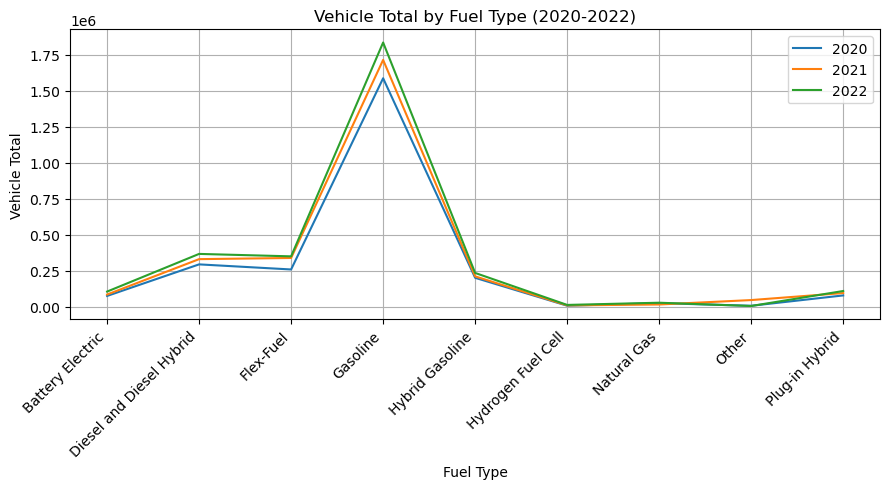

In [17]:
# Data for 2020
fuel_types_2020 = {
    'Battery Electric': 76020,
    'Diesel and Diesel Hybrid': 295075,
    'Flex-Fuel': 259780,
    'Gasoline': 1586575,
    'Hybrid Gasoline': 201905,
    'Hydrogen Fuel Cell': 8415,
    'Natural Gas': 26260,
    'Other': 7770,
    'Plug-in Hybrid': 79645
}

# Data for 2021
fuel_types_2021 = {
    'Battery Electric': 85820,
    'Diesel and Diesel Hybrid': 331395,
    'Flex-Fuel': 339580,
    'Gasoline': 1713775,
    'Hybrid Gasoline': 211950,
    'Hydrogen Fuel Cell': 10490,
    'Natural Gas': 16750,
    'Other': 47445,
    'Plug-in Hybrid': 96090
}

# Data for 2022
fuel_types_2022 = {
    'Battery Electric': 106290,
    'Diesel and Diesel Hybrid': 367745,
    'Flex-Fuel': 350785,
    'Gasoline': 1834675,
    'Hybrid Gasoline': 235670,
    'Hydrogen Fuel Cell': 13705,
    'Natural Gas': 29005,
    'Other': 6280,
    'Plug-in Hybrid': 110320
}

# Extract fuel types and vehicle totals
fuel_types = list(fuel_types_2020.keys())
vehicles_2020 = list(fuel_types_2020.values())
vehicles_2021 = list(fuel_types_2021.values())
vehicles_2022 = list(fuel_types_2022.values())

# Plotting
plt.figure(figsize=(9, 5))
plt.plot(fuel_types, vehicles_2020, label='2020')
plt.plot(fuel_types, vehicles_2021, label='2021')
plt.plot(fuel_types, vehicles_2022, label='2022')

# Customizing the plot
plt.xlabel('Fuel Type')
plt.ylabel('Vehicle Total')
plt.title('Vehicle Total by Fuel Type (2020-2022)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [18]:
battery_electric_data = merged_data_all[merged_data_all['Fuel'] == 'Battery Electric']
#battery_electric_data = battery_electric_data.drop_duplicates()
battery_electric_data

,Date,Zipcode,Fuel,Vehicles,Year,county
94987,1/1/2020,92220,Battery Electric,1,2020,Riverside
94988,1/1/2020,92220,Battery Electric,1,2020,Riverside
94989,1/1/2020,92220,Battery Electric,1,2020,Riverside
94990,1/1/2020,92220,Battery Electric,1,2020,Riverside
94991,1/1/2020,92220,Battery Electric,1,2020,Riverside
...,...,...,...,...,...,...
8762058,1/1/2022,OOS,Battery Electric,17,2022,NaN
8762059,1/1/2022,OOS,Battery Electric,22,2022,NaN
8762060,1/1/2022,OOS,Battery Electric,14,2022,NaN
8762061,1/1/2022,OOS,Battery Electric,278,2022,NaN


In [19]:
# filtering the DataFrame by 'Zip Code' to calculate the sum of 'Vehicles' for each zip code
battery_electric_totals = battery_electric_data.groupby(['county','Fuel', 'Year']).agg({'Vehicles': 'count'}).reset_index()

battery_electric_totals


,county,Fuel,Year,Vehicles
0,Alameda,Battery Electric,2020,4340
1,Alameda,Battery Electric,2021,4750
2,Alameda,Battery Electric,2022,5580
3,Alpine,Battery Electric,2020,5
4,Alpine,Battery Electric,2021,15
...,...,...,...,...
165,Yolo,Battery Electric,2021,615
166,Yolo,Battery Electric,2022,765
167,Yuba,Battery Electric,2020,150
168,Yuba,Battery Electric,2021,160


In [20]:
# dropping two counties: Sierra and Modoc, total counties will be 56

# filtering the DataFrame by ‘Zip Code’ to calculate the sum of ‘Vehicles’ for each zip code
battery_electric_totals = battery_electric_data.groupby(['county','Fuel', 'Year']).agg({'Vehicles': 'count'}).reset_index()
# We also need to drop any counties where we don’t have all three years of data...
# To do that, we want to find a list of counties
keepcounty = battery_electric_totals.groupby('county').count()
keepcounty = keepcounty.loc[keepcounty['Fuel'] == 3]
# Now we can delete any rows from multi_census_pd
# Where the Zipcode is not in the ‘keepzip’ file
battery_electric_totals = battery_electric_totals[battery_electric_totals['county'].isin(keepcounty.index)]
# totals for each zip code
battery_electric_totals

,county,Fuel,Year,Vehicles
0,Alameda,Battery Electric,2020,4340
1,Alameda,Battery Electric,2021,4750
2,Alameda,Battery Electric,2022,5580
3,Alpine,Battery Electric,2020,5
4,Alpine,Battery Electric,2021,15
...,...,...,...,...
165,Yolo,Battery Electric,2021,615
166,Yolo,Battery Electric,2022,765
167,Yuba,Battery Electric,2020,150
168,Yuba,Battery Electric,2021,160


In [21]:
# saving the merged data to a new csv, after the dropped fields
battery_electric_totals.to_csv('battery_electric_totals.csv', index=False)

In [22]:
num_counties = battery_electric_totals['county'].nunique()
num_counties

56

BAR CHART FOR NUMBER OF EV PER COUNTY AND YEAR

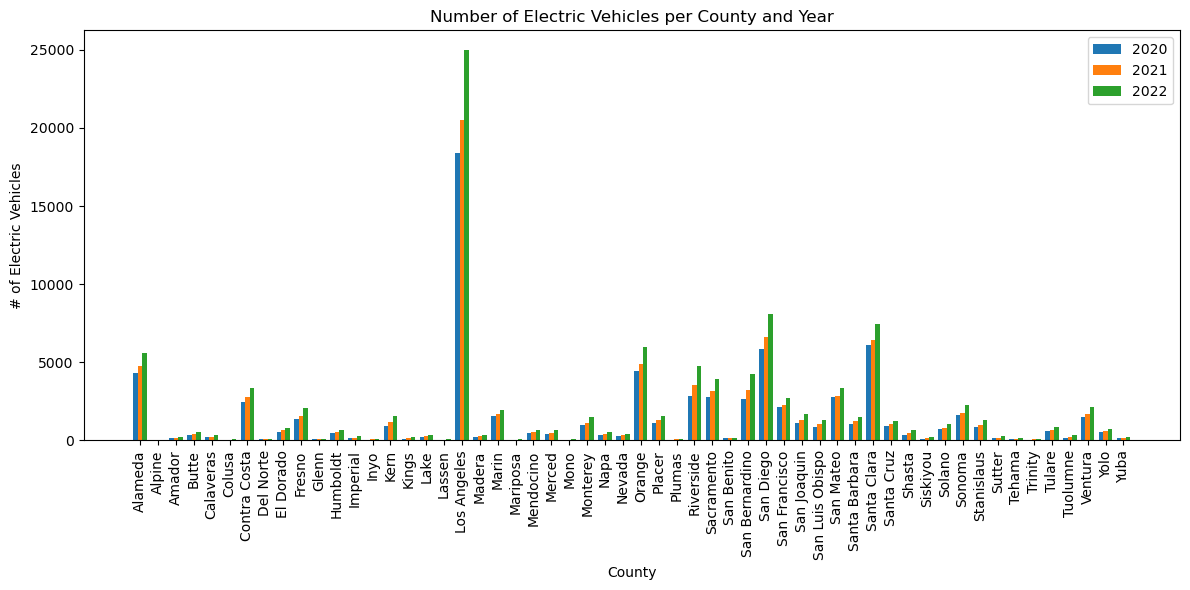

In [23]:
pivot_df = battery_electric_totals.pivot(index='county', columns='Year', values='Vehicles')

# Plotting
plt.figure(figsize=(12, 6))

# Define x positions for bars
x = np.arange(len(pivot_df.index))

# Width of each bar
width = 0.25

# Plot bars for each year
plt.bar(x - width, pivot_df[2020], width, label='2020')
plt.bar(x, pivot_df[2021], width, label='2021')
plt.bar(x + width, pivot_df[2022], width, label='2022')

# Add labels and title
plt.xlabel('County')
plt.ylabel('# of Electric Vehicles')
plt.title('Number of Electric Vehicles per County and Year')
plt.xticks(x, pivot_df.index, rotation=90)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [24]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Calculate the percentage increase from 2020 to 2021
increase_2021 = ((pivot_df[2021] - pivot_df[2020]) / pivot_df[2020]) * 100

# Calculate the percentage increase from 2021 to 2022
increase_2022 = ((pivot_df[2022] - pivot_df[2021]) / pivot_df[2021]) * 100

# Combine the increase rates into a DataFrame
increase_rates = pd.DataFrame({'Increase Rate 2021': increase_2021, 'Increase Rate 2022': increase_2022})

# Display the increase rates
print("Increase Rates:")
increase_rates


Increase Rates:


,Increase Rate 2021,Increase Rate 2022
county,,
Alameda,9.447005,17.473684
Alpine,200.000000,100.000000
Amador,42.307692,27.027027
Butte,17.808219,27.906977
Calaveras,13.636364,40.000000
Colusa,100.000000,83.333333
Contra Costa,14.579055,20.788530
Del Norte,17.647059,10.000000
El Dorado,22.321429,15.328467


In [25]:
total_by_year = battery_electric_totals.groupby('Year')['Vehicles'].sum()

# Display the total number of battery electric vehicles for each year
total_by_year

Year
2020     76020
2021     85820
2022    106275
Name: Vehicles, dtype: int64

# Ending of Gina

Going into the project, I was expecting to see a large gap in the adoption rate of EV's between urban and rural counties. The expectation was that the longer distances required to get to a public charging station coupled with the longer driving distances in general for residents of rural counties would significantly reduce the number of EV's purchased and operated in rural counties on a per capita basis. That turned out not to be the case. Rural counties have an average of 218 EV car registrations per year per 100,000 residents across the three years for which DMV data were available, while urban counties had an average of about 2Going into the project, I was expecting to see a large gap in the adoption rate of EV's between urban and rural counties. The expectation was that the longer distances required to get to a public charging station coupled with the longer driving distances in general for residents of rural counties would significantly reduce the number of EV's purchased and operated in rural counties on a per capita basis. That turned out not to be the case. Rural counties have an average of 218 EV car registrations per year per 100,000 residents across the three years for which DMV data were available, while urban counties had an average of about 234 EV car registrations per year per 100,000, only 7% higher than rural counties. In addition, that gap is narrowing with 2022 data almost exactly matching between urban and rural locations in California.34 EV car registrations per year per 100,000, only 7% higher than rural counties. In addition, that gap is narrowing with 2022 data almost exactly matching between urban and rural locations in California.

In looking at the data for the eight largest counties, both urban and rural, there is one trend to note: adoption rates appear somewhat higher in total over the three years for northern california urban counties than for southern california urban counties. The differences in the rural counties are much smaller with adoption rates being vary similar across the board. 

There are two significant weaknesses in the datasets that should be pointed out. First, only three years of DMV were available, so extrapolation of current trends into future years would be quite risky. Second, the classification of rural vs. urban may be generally correct, but there are some counties that have significant urban populations--perhaps even mostly urban populations--that are considered "rural" simply because they are so large. The most obvious of these is San Diego county. 

# Beginning of Aram (EV_Chargers.ipynb)

In [26]:
# Dependencies and setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

#  Data
EV_Chargers_Path = "EV_Chargers1.csv"

# Read the data
EV_Chargers_data = pd.read_csv(EV_Chargers_Path)

# Preview data
EV_Chargers_data.head()

,County,Q4 2023,Q3 2023,Q2 2023,Q4 2022,Q3 2022,Q2 2022,Q1 2022,Q4 2021,Q3 2021,Q2 2021,Q1 2021,Q4 2020,Q3 2020,Q2 2020
0,Alameda,5893,4624,4504,4430,4282,5139,5051,3697,3625,3560,3544,3353,3082,2990
1,Alpine,12,10,10,6,16,16,18,14,15,15,15,15,13,12
2,Amador,34,34,34,34,33,33,33,39,40,40,40,40,30,29
3,Butte,157,149,147,146,139,158,132,94,92,91,82,76,76,74
4,Calaveras,23,23,21,25,23,23,21,21,21,19,19,7,7,7


In [27]:
# Data in the form of a list of lists
data = [
    ['Alameda', 5893, 4624, 4504, 4430, 4282, 5139, 5051, 3697, 3625, 3560, 3544, 3353, 3082, 2990],
    ['Alpine', 12, 10, 10, 6, 16, 16, 18, 14, 15, 15, 15, 15, 13, 12],
    ['Amador', 34, 34, 34, 34, 33, 33, 33, 39, 40, 40, 40, 40, 30, 29],
    ['Butte', 157, 149, 147, 146, 139, 158, 132, 94, 92, 91, 82, 76, 76, 74],
    ['Calaveras', 23, 23, 21, 25, 23, 23, 21, 21, 21, 19, 19, 7, 7, 7],
    ['Colusa', 37, 36, 36, 34, 34, 36, 36, 38, 34, 30, 28, 28, 28, 28],
    ['Contra Costa', 1632, 1734, 1674, 1503, 1495, 1699, 1715, 1451, 1483, 1461, 1455, 1355, 1325, 1068],
    ['Del Norte', 46, 47, 47, 39, 39, 32, 32, 29, 29, 25, 25, 30, 30, 30],
    ['El Dorado', 258, 214, 202, 189, 194, 193, 173, 179, 181, 177, 167, 173, 160, 150],
    ['Fresno', 1292, 1313, 1373, 1291, 1158, 1321, 1311, 1133, 1143, 1127, 1092, 921, 779, 684],
    ['Glenn', 8, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
    ['Humboldt', 157, 157, 157, 154, 150, 148, 145, 150, 142, 134, 124, 112, 114, 105],
    ['Imperial', 52, 50, 50, 49, 45, 43, 35, 31, 33, 33, 33, 27, 27, 15],
    ['Inyo', 83, 54, 52, 48, 49, 49, 41, 42, 39, 39, 35, 37, 23, 23],
    ['Kern', 832, 797, 721, 691, 646, 629, 631, 416, 359, 306, 298, 279, 279, 241],
    ['Kings', 431, 419, 410, 410, 176, 168, 160, 204, 148, 147, 147, 144, 140, 122],
    ['Lake', 18, 17, 14, 14, 15, 15, 14, 14, 17, 17, 15, 15, 15, 10],
    ['Lassen', 16, 16, 16, 16, 16, 16, 13, 13, 14, 6, 6, 5, 5, 4],
    ['Los Angeles', 31569, 29433, 29051, 27015, 25685, 24615, 23903, 20950, 20520, 20193, 19872, 19236, 18509, 16770],
    ['Madera', 203, 202, 203, 190, 161, 152, 147, 130, 122, 121, 121, 113, 89, 84],
    ['Marin', 1020, 1082, 1048, 1027, 933, 1052, 1037, 739, 734, 730, 728, 706, 684, 629],
    ['Mariposa', 62, 59, 60, 46, 33, 45, 35, 24, 30, 16, 16, 16, 16, 16],
    ['Mendocino', 229, 214, 203, 186, 200, 162, 158, 160, 158, 158, 146, 144, 129, 110],
    ['Merced', 182, 155, 124, 135, 177, 134, 139, 125, 142, 142, 138, 130, 114, 94],
    ['Modoc', 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4, 4, 4, 4],
    ['Mono', 52, 38, 38, 38, 38, 37, 37, 32, 32, 32, 32, 32, 31, 31],
    ['Monterey', 491, 480, 487, 424, 394, 400, 383, 452, 425, 431, 424, 422, 360, 348],
    ['Napa', 478, 442, 433, 396, 391, 403, 393, 393, 390, 388, 386, 374, 348, 316],
    ['Nevada', 149, 144, 144, 169, 161, 152, 152, 116, 89, 88, 88, 93, 88, 86],
    ['Orange', 6771, 6002, 5797, 5383, 5214, 5189, 5003, 5852, 5657, 5477, 5381, 5242, 4886, 4799],
    ['Placer', 622, 522, 518, 455, 425, 448, 424, 419, 402, 365, 361, 351, 339, 305],
    ['Plumas', 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 5, 5],
    ['Riverside', 1835, 1835, 1745, 1635, 1508, 1493, 1441, 1548, 1495, 1441, 1422, 1464, 1360, 1306],
    ['Sacramento', 2253, 2205, 2149, 2040, 1756, 1839, 1765, 1813, 1836, 1852, 1850, 1777, 1765, 1438],
    ['San Benito', 27, 29, 28, 45, 43, 47, 47, 47, 49, 47, 47, 50, 42, 44],
    ['San Bernardino', 1957, 1841, 1767, 1682, 1615, 1560, 1424, 1367, 1478, 1415, 1395, 1338, 1297, 999],
    ['San Diego', 8583, 8094, 7960, 7735, 7358, 7074, 6551, 10080, 7278, 7199, 7170, 6874, 6760, 6073],
    ['San Francisco', 2431, 2070, 2002, 1952, 1436, 1575, 1519, 1630, 1840, 1671, 1609, 1505, 1384, 1264],
    ['San Joaquin', 825, 728, 680, 632, 612, 596, 565, 442, 407, 402, 397, 389, 326, 306],
    ['San Luis Obispo', 777, 705, 694, 650, 616, 640, 638, 566, 513, 513, 493, 493, 486, 442],
    ['San Mateo', 5533, 4798, 4619, 4557, 4436, 4799, 4688, 4511, 4701, 4459, 4282, 4070, 3758, 3617],
    ['Santa Barbara', 648, 526, 566, 512, 504, 515, 480, 557, 522, 492, 499, 494, 461, 437],
    ['Santa Clara', 20220, 18193, 17865, 17621, 16227, 16981, 16831, 15987, 16498, 16202, 16119, 15406, 14913, 14164],
    ['Santa Cruz', 359, 369, 356, 359, 345, 356, 333, 307, 306, 300, 302, 281, 262, 250],
    ['Shasta', 227, 179, 174, 153, 138, 105, 90, 86, 92, 93, 93, 96, 94, 57],
    ['Sierra', 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ['Siskiyou', 77, 69, 68, 67, 67, 68, 68, 72, 68, 67, 56, 63, 63, 55],
    ['Solano', 608, 578, 560, 482, 473, 509, 501, 471, 421, 421, 394, 372, 362, 369],
    ['Sonoma', 902, 871, 845, 816, 794, 840, 765, 794, 803, 791, 789, 743, 695, 670],
    ['Stanislaus', 249, 202, 178, 188, 171, 158, 149, 151, 158, 150, 151, 145, 145, 122],
    ['Sutter', 35, 31, 24, 22, 27, 24, 24, 27, 33, 31, 31, 31, 23, 20],
    ['Tehama', 94, 91, 91, 87, 91, 80, 66, 35, 31, 30, 31, 32, 32, 32],
    ['Trinity', 15, 12, 14, 14, 14, 14, 14, 6, 6, 6, 6, 8, 8, 4],
    ['Tulare', 291, 275, 279, 231, 212, 160, 154, 123, 124, 119, 108, 103, 85, 76],
    ['Tuolumne', 55, 54, 54, 58, 60, 52, 52, 78, 54, 50, 50, 47, 47, 45],
    ['Ventura', 930, 875, 870, 858, 810, 821, 273, 14, 11, 11, 11, 11, 13, 749],
    ['Yolo', 468, 432, 427, 412, 398, 428, 679, 894, 894, 893, 892, 845, 868, 264],
    ['Yuba', 69, 80, 79, 75, 59, 60, 299, 394, 388, 386, 386, 324, 328, 14],
    ['Unknown', 3368, 807, 807, 807, 1868, 16, 41, 32, 16, 16, 16, 16, 16, 16]
]

# Columns for the DataFrame
columns = ['County', 'Q4 2023', 'Q3 2023', 'Q2 2023', 'Q1 2023', 'Q4 2022', 'Q3 2022', 'Q2 2022', 
           'Q1 2022', 'Q4 2021', 'Q3 2021', 'Q2 2021', 'Q1 2021', 'Q4 2020', 'Q3 2020']

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Print 
print(df)


             County  Q4 2023  Q3 2023  Q2 2023  Q1 2023  Q4 2022  Q3 2022  \
0           Alameda     5893     4624     4504     4430     4282     5139   
1            Alpine       12       10       10        6       16       16   
2            Amador       34       34       34       34       33       33   
3             Butte      157      149      147      146      139      158   
4         Calaveras       23       23       21       25       23       23   
5            Colusa       37       36       36       34       34       36   
6      Contra Costa     1632     1734     1674     1503     1495     1699   
7         Del Norte       46       47       47       39       39       32   
8         El Dorado      258      214      202      189      194      193   
9            Fresno     1292     1313     1373     1291     1158     1321   
10            Glenn        8       14       14       14       14       14   
11         Humboldt      157      157      157      154      150      148   

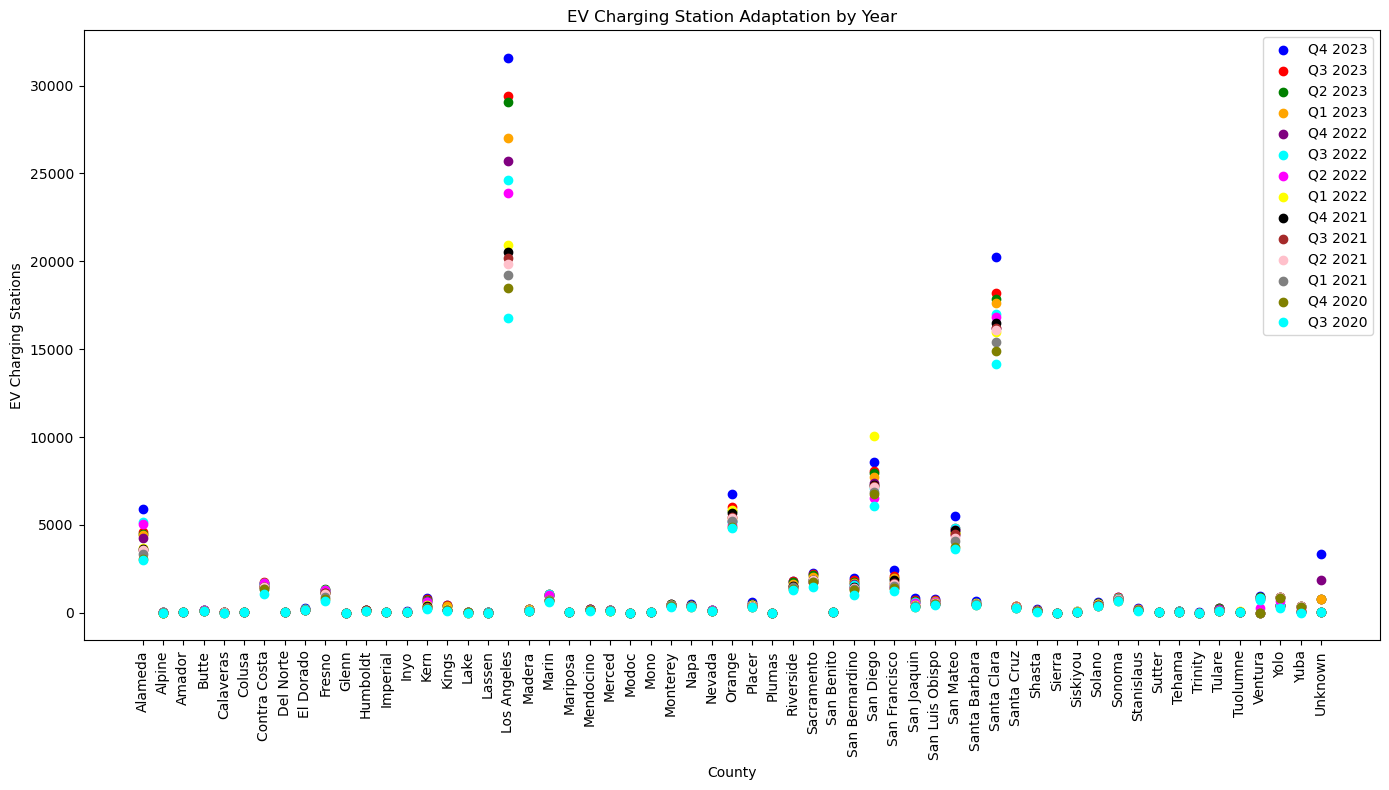

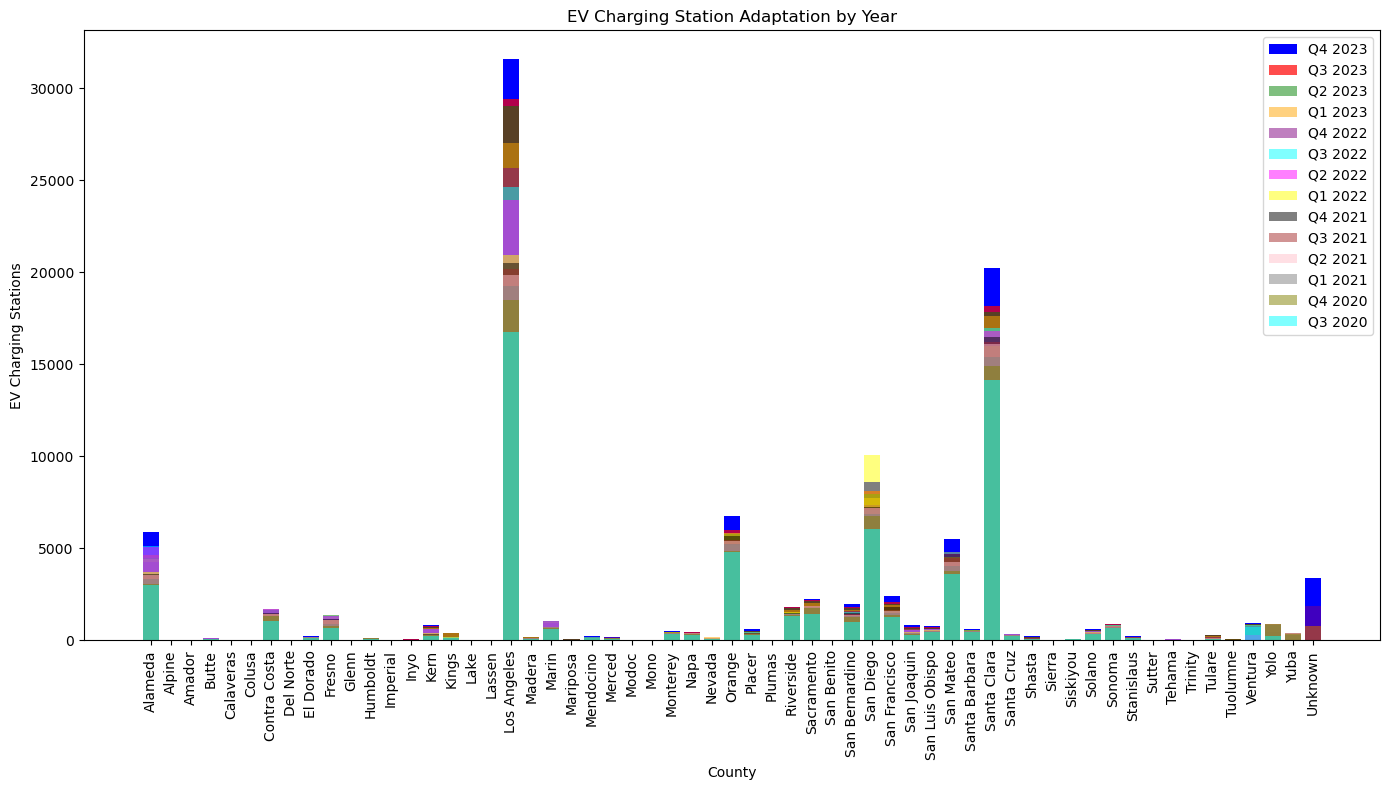

In [28]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(14, 8))
plt.scatter(df['County'], df['Q4 2023'], color='blue', label='Q4 2023')
plt.scatter(df['County'], df['Q3 2023'], color='red', label='Q3 2023')
plt.scatter(df['County'], df['Q2 2023'], color='green', label='Q2 2023')
plt.scatter(df['County'], df['Q1 2023'], color='orange', label='Q1 2023')
plt.scatter(df['County'], df['Q4 2022'], color='purple', label='Q4 2022')
plt.scatter(df['County'], df['Q3 2022'], color='cyan', label='Q3 2022')
plt.scatter(df['County'], df['Q2 2022'], color='magenta', label='Q2 2022')
plt.scatter(df['County'], df['Q1 2022'], color='yellow', label='Q1 2022')
plt.scatter(df['County'], df['Q4 2021'], color='black', label='Q4 2021')
plt.scatter(df['County'], df['Q3 2021'], color='brown', label='Q3 2021')
plt.scatter(df['County'], df['Q2 2021'], color='pink', label='Q2 2021')
plt.scatter(df['County'], df['Q1 2021'], color='gray', label='Q1 2021')
plt.scatter(df['County'], df['Q4 2020'], color='olive', label='Q4 2020')
plt.scatter(df['County'], df['Q3 2020'], color='cyan', label='Q3 2020')

plt.xlabel('County')
plt.ylabel('EV Charging Stations')
plt.title('EV Charging Station Adaptation by Year')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Bar plot
plt.figure(figsize=(14, 8))
plt.bar(df['County'], df['Q4 2023'], color='blue', label='Q4 2023')
plt.bar(df['County'], df['Q3 2023'], color='red', label='Q3 2023', alpha=0.7)
plt.bar(df['County'], df['Q2 2023'], color='green', label='Q2 2023', alpha=0.5)
plt.bar(df['County'], df['Q1 2023'], color='orange', label='Q1 2023', alpha=0.5)
plt.bar(df['County'], df['Q4 2022'], color='purple', label='Q4 2022', alpha=0.5)
plt.bar(df['County'], df['Q3 2022'], color='cyan', label='Q3 2022', alpha=0.5)
plt.bar(df['County'], df['Q2 2022'], color='magenta', label='Q2 2022', alpha=0.5)
plt.bar(df['County'], df['Q1 2022'], color='yellow', label='Q1 2022', alpha=0.5)
plt.bar(df['County'], df['Q4 2021'], color='black', label='Q4 2021', alpha=0.5)
plt.bar(df['County'], df['Q3 2021'], color='brown', label='Q3 2021', alpha=0.5)
plt.bar(df['County'], df['Q2 2021'], color='pink', label='Q2 2021', alpha=0.5)
plt.bar(df['County'], df['Q1 2021'], color='gray', label='Q1 2021', alpha=0.5)
plt.bar(df['County'], df['Q4 2020'], color='olive', label='Q4 2020', alpha=0.5)
plt.bar(df['County'], df['Q3 2020'], color='cyan', label='Q3 2020', alpha=0.5)

plt.xlabel('County')
plt.ylabel('EV Charging Stations')
plt.title('EV Charging Station Adaptation by Year')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Ending of Aram (EV_Chargers.ipynb)

# Beginning of Aram (Charging_Stations_by_County.ipynb)

In [29]:
# Dependencies and setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

#  Data
EV_Chargers_Path = "EV_Chargers1.csv"

# Read the data
EV_Chargers_data = pd.read_csv(EV_Chargers_Path)

# Preview data
EV_Chargers_data.head()

,County,Q4 2023,Q3 2023,Q2 2023,Q4 2022,Q3 2022,Q2 2022,Q1 2022,Q4 2021,Q3 2021,Q2 2021,Q1 2021,Q4 2020,Q3 2020,Q2 2020
0,Alameda,5893,4624,4504,4430,4282,5139,5051,3697,3625,3560,3544,3353,3082,2990
1,Alpine,12,10,10,6,16,16,18,14,15,15,15,15,13,12
2,Amador,34,34,34,34,33,33,33,39,40,40,40,40,30,29
3,Butte,157,149,147,146,139,158,132,94,92,91,82,76,76,74
4,Calaveras,23,23,21,25,23,23,21,21,21,19,19,7,7,7


In [30]:
# Data in the form of a list of lists
data = [
    ['Alameda', 5893, 4624, 4504, 4430, 4282, 5139, 5051, 3697, 3625, 3560, 3544, 3353, 3082, 2990],
    ['Alpine', 12, 10, 10, 6, 16, 16, 18, 14, 15, 15, 15, 15, 13, 12],
    ['Amador', 34, 34, 34, 34, 33, 33, 33, 39, 40, 40, 40, 40, 30, 29],
    ['Butte', 157, 149, 147, 146, 139, 158, 132, 94, 92, 91, 82, 76, 76, 74],
    ['Calaveras', 23, 23, 21, 25, 23, 23, 21, 21, 21, 19, 19, 7, 7, 7],
    ['Colusa', 37, 36, 36, 34, 34, 36, 36, 38, 34, 30, 28, 28, 28, 28],
    ['Contra Costa', 1632, 1734, 1674, 1503, 1495, 1699, 1715, 1451, 1483, 1461, 1455, 1355, 1325, 1068],
    ['Del Norte', 46, 47, 47, 39, 39, 32, 32, 29, 29, 25, 25, 30, 30, 30],
    ['El Dorado', 258, 214, 202, 189, 194, 193, 173, 179, 181, 177, 167, 173, 160, 150],
    ['Fresno', 1292, 1313, 1373, 1291, 1158, 1321, 1311, 1133, 1143, 1127, 1092, 921, 779, 684],
    ['Glenn', 8, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
    ['Humboldt', 157, 157, 157, 154, 150, 148, 145, 150, 142, 134, 124, 112, 114, 105],
    ['Imperial', 52, 50, 50, 49, 45, 43, 35, 31, 33, 33, 33, 27, 27, 15],
    ['Inyo', 83, 54, 52, 48, 49, 49, 41, 42, 39, 39, 35, 37, 23, 23],
    ['Kern', 832, 797, 721, 691, 646, 629, 631, 416, 359, 306, 298, 279, 279, 241],
    ['Kings', 431, 419, 410, 410, 176, 168, 160, 204, 148, 147, 147, 144, 140, 122],
    ['Lake', 18, 17, 14, 14, 15, 15, 14, 14, 17, 17, 15, 15, 15, 10],
    ['Lassen', 16, 16, 16, 16, 16, 16, 13, 13, 14, 6, 6, 5, 5, 4],
    ['Los Angeles', 31569, 29433, 29051, 27015, 25685, 24615, 23903, 20950, 20520, 20193, 19872, 19236, 18509, 16770],
    ['Madera', 203, 202, 203, 190, 161, 152, 147, 130, 122, 121, 121, 113, 89, 84],
    ['Marin', 1020, 1082, 1048, 1027, 933, 1052, 1037, 739, 734, 730, 728, 706, 684, 629],
    ['Mariposa', 62, 59, 60, 46, 33, 45, 35, 24, 30, 16, 16, 16, 16, 16],
    ['Mendocino', 229, 214, 203, 186, 200, 162, 158, 160, 158, 158, 146, 144, 129, 110],
    ['Merced', 182, 155, 124, 135, 177, 134, 139, 125, 142, 142, 138, 130, 114, 94],
    ['Modoc', 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 4, 4, 4, 4],
    ['Mono', 52, 38, 38, 38, 38, 37, 37, 32, 32, 32, 32, 32, 31, 31],
    ['Monterey', 491, 480, 487, 424, 394, 400, 383, 452, 425, 431, 424, 422, 360, 348],
    ['Napa', 478, 442, 433, 396, 391, 403, 393, 393, 390, 388, 386, 374, 348, 316],
    ['Nevada', 149, 144, 144, 169, 161, 152, 152, 116, 89, 88, 88, 93, 88, 86],
    ['Orange', 6771, 6002, 5797, 5383, 5214, 5189, 5003, 5852, 5657, 5477, 5381, 5242, 4886, 4799],
    ['Placer', 622, 522, 518, 455, 425, 448, 424, 419, 402, 365, 361, 351, 339, 305],
    ['Plumas', 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 5, 5],
    ['Riverside', 1835, 1835, 1745, 1635, 1508, 1493, 1441, 1548, 1495, 1441, 1422, 1464, 1360, 1306],
    ['Sacramento', 2253, 2205, 2149, 2040, 1756, 1839, 1765, 1813, 1836, 1852, 1850, 1777, 1765, 1438],
    ['San Benito', 27, 29, 28, 45, 43, 47, 47, 47, 49, 47, 47, 50, 42, 44],
    ['San Bernardino', 1957, 1841, 1767, 1682, 1615, 1560, 1424, 1367, 1478, 1415, 1395, 1338, 1297, 999],
    ['San Diego', 8583, 8094, 7960, 7735, 7358, 7074, 6551, 10080, 7278, 7199, 7170, 6874, 6760, 6073],
    ['San Francisco', 2431, 2070, 2002, 1952, 1436, 1575, 1519, 1630, 1840, 1671, 1609, 1505, 1384, 1264],
    ['San Joaquin', 825, 728, 680, 632, 612, 596, 565, 442, 407, 402, 397, 389, 326, 306],
    ['San Luis Obispo', 777, 705, 694, 650, 616, 640, 638, 566, 513, 513, 493, 493, 486, 442],
    ['San Mateo', 5533, 4798, 4619, 4557, 4436, 4799, 4688, 4511, 4701, 4459, 4282, 4070, 3758, 3617],
    ['Santa Barbara', 648, 526, 566, 512, 504, 515, 480, 557, 522, 492, 499, 494, 461, 437],
    ['Santa Clara', 20220, 18193, 17865, 17621, 16227, 16981, 16831, 15987, 16498, 16202, 16119, 15406, 14913, 14164],
    ['Santa Cruz', 359, 369, 356, 359, 345, 356, 333, 307, 306, 300, 302, 281, 262, 250],
    ['Shasta', 227, 179, 174, 153, 138, 105, 90, 86, 92, 93, 93, 96, 94, 57],
    ['Sierra', 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ['Siskiyou', 77, 69, 68, 67, 67, 68, 68, 72, 68, 67, 56, 63, 63, 55],
    ['Solano', 608, 578, 560, 482, 473, 509, 501, 471, 421, 421, 394, 372, 362, 369],
    ['Sonoma', 902, 871, 845, 816, 794, 840, 765, 794, 803, 791, 789, 743, 695, 670],
    ['Stanislaus', 249, 202, 178, 188, 171, 158, 149, 151, 158, 150, 151, 145, 145, 122],
    ['Sutter', 35, 31, 24, 22, 27, 24, 24, 27, 33, 31, 31, 31, 23, 20],
    ['Tehama', 94, 91, 91, 87, 91, 80, 66, 35, 31, 30, 31, 32, 32, 32],
    ['Trinity', 15, 12, 14, 14, 14, 14, 14, 6, 6, 6, 6, 8, 8, 4],
    ['Tulare', 291, 275, 279, 231, 212, 160, 154, 123, 124, 119, 108, 103, 85, 76],
    ['Tuolumne', 55, 54, 54, 58, 60, 52, 52, 78, 54, 50, 50, 47, 47, 45],
    ['Ventura', 930, 875, 870, 858, 810, 821, 273, 14, 11, 11, 11, 11, 13, 749],
    ['Yolo', 468, 432, 427, 412, 398, 428, 679, 894, 894, 893, 892, 845, 868, 264],
    ['Yuba', 69, 80, 79, 75, 59, 60, 299, 394, 388, 386, 386, 324, 328, 14],
]

# Columns for the DataFrame
columns = ['County', 'Q4 2023', 'Q3 2023', 'Q2 2023', 'Q1 2023', 'Q4 2022', 'Q3 2022', 'Q2 2022', 
           'Q1 2022', 'Q4 2021', 'Q3 2021', 'Q2 2021', 'Q1 2021', 'Q4 2020', 'Q3 2020']

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Print 
print(df)

             County  Q4 2023  Q3 2023  Q2 2023  Q1 2023  Q4 2022  Q3 2022  \
0           Alameda     5893     4624     4504     4430     4282     5139   
1            Alpine       12       10       10        6       16       16   
2            Amador       34       34       34       34       33       33   
3             Butte      157      149      147      146      139      158   
4         Calaveras       23       23       21       25       23       23   
5            Colusa       37       36       36       34       34       36   
6      Contra Costa     1632     1734     1674     1503     1495     1699   
7         Del Norte       46       47       47       39       39       32   
8         El Dorado      258      214      202      189      194      193   
9            Fresno     1292     1313     1373     1291     1158     1321   
10            Glenn        8       14       14       14       14       14   
11         Humboldt      157      157      157      154      150      148   

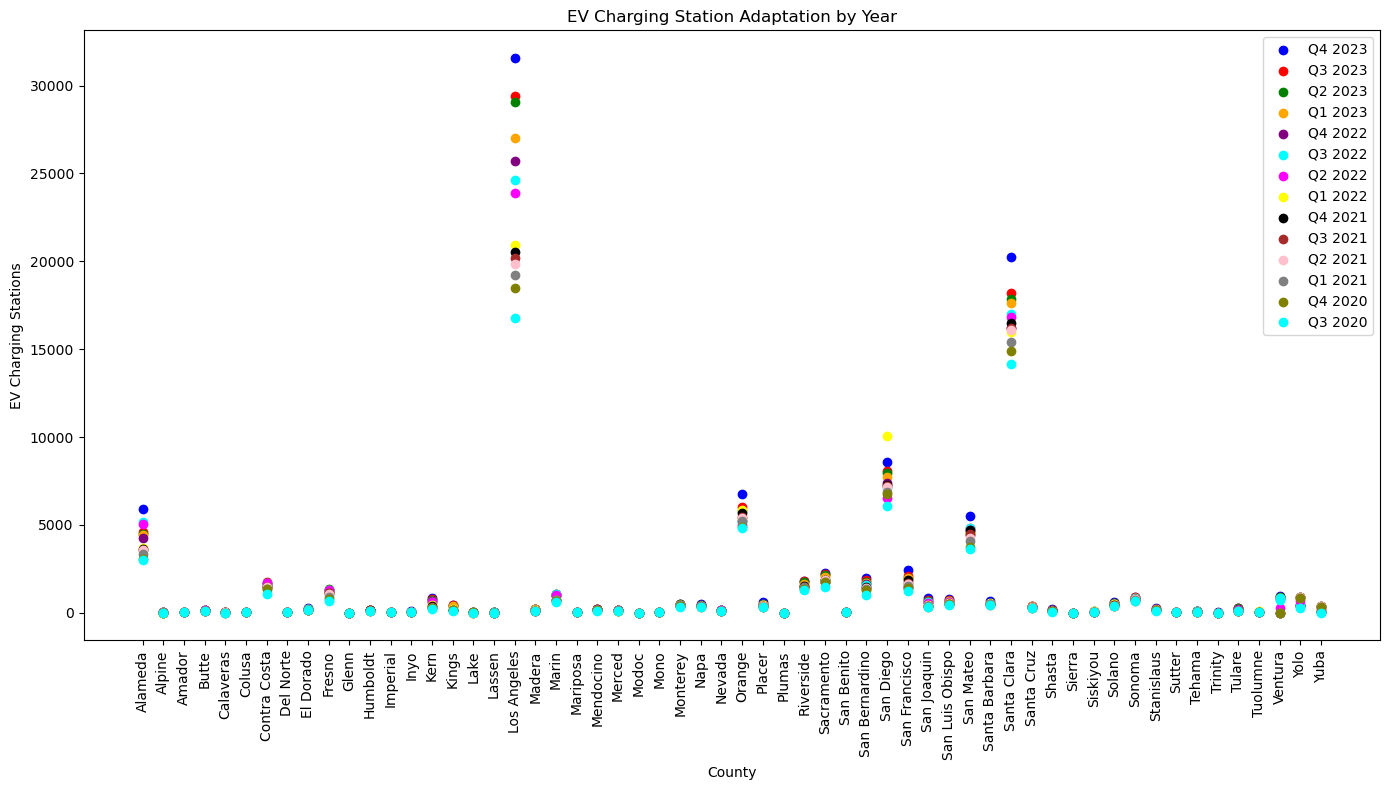

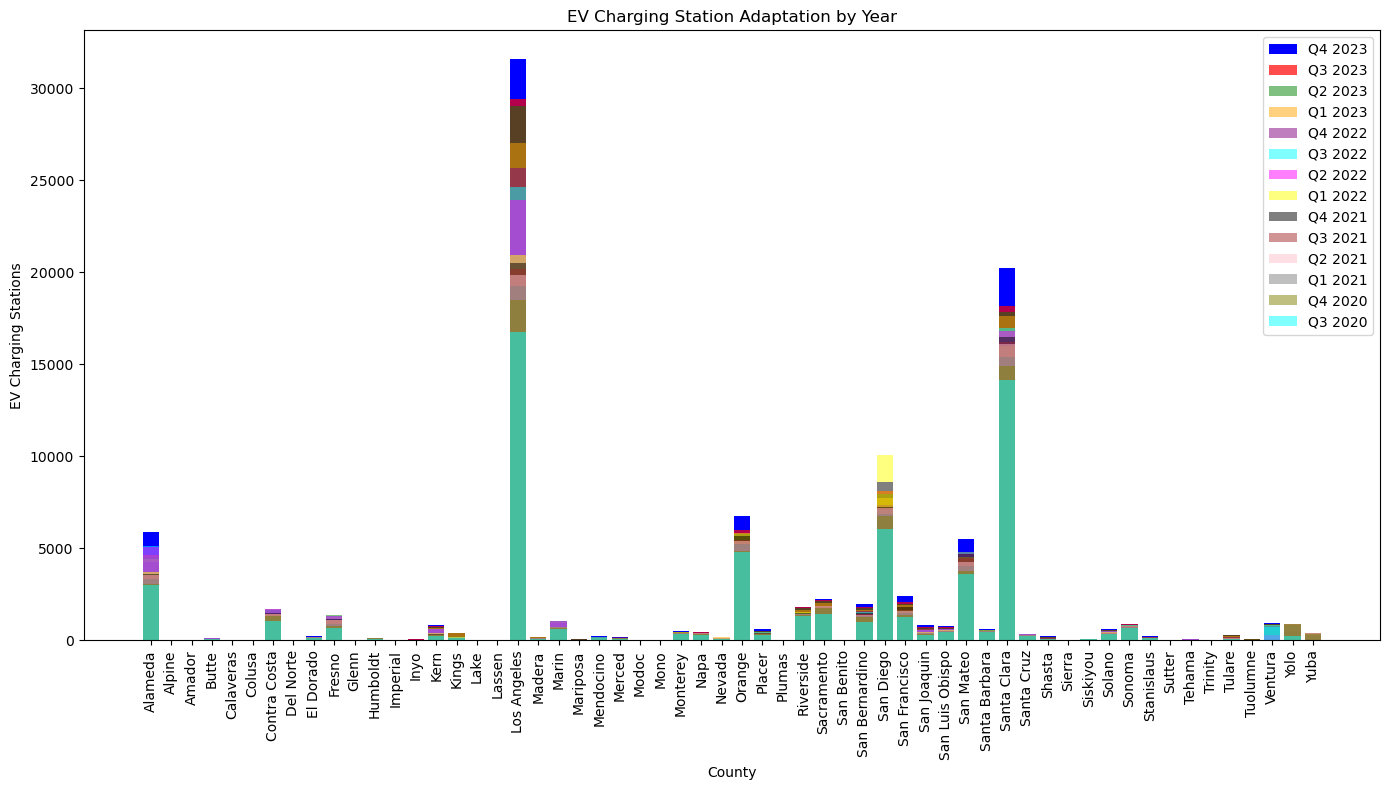

In [31]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(14, 8))
plt.scatter(df['County'], df['Q4 2023'], color='blue', label='Q4 2023')
plt.scatter(df['County'], df['Q3 2023'], color='red', label='Q3 2023')
plt.scatter(df['County'], df['Q2 2023'], color='green', label='Q2 2023')
plt.scatter(df['County'], df['Q1 2023'], color='orange', label='Q1 2023')
plt.scatter(df['County'], df['Q4 2022'], color='purple', label='Q4 2022')
plt.scatter(df['County'], df['Q3 2022'], color='cyan', label='Q3 2022')
plt.scatter(df['County'], df['Q2 2022'], color='magenta', label='Q2 2022')
plt.scatter(df['County'], df['Q1 2022'], color='yellow', label='Q1 2022')
plt.scatter(df['County'], df['Q4 2021'], color='black', label='Q4 2021')
plt.scatter(df['County'], df['Q3 2021'], color='brown', label='Q3 2021')
plt.scatter(df['County'], df['Q2 2021'], color='pink', label='Q2 2021')
plt.scatter(df['County'], df['Q1 2021'], color='gray', label='Q1 2021')
plt.scatter(df['County'], df['Q4 2020'], color='olive', label='Q4 2020')
plt.scatter(df['County'], df['Q3 2020'], color='cyan', label='Q3 2020')

plt.xlabel('County')
plt.ylabel('EV Charging Stations')
plt.title('EV Charging Station Adaptation by Year')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Bar plot
plt.figure(figsize=(14, 8))
plt.bar(df['County'], df['Q4 2023'], color='blue', label='Q4 2023')
plt.bar(df['County'], df['Q3 2023'], color='red', label='Q3 2023', alpha=0.7)
plt.bar(df['County'], df['Q2 2023'], color='green', label='Q2 2023', alpha=0.5)
plt.bar(df['County'], df['Q1 2023'], color='orange', label='Q1 2023', alpha=0.5)
plt.bar(df['County'], df['Q4 2022'], color='purple', label='Q4 2022', alpha=0.5)
plt.bar(df['County'], df['Q3 2022'], color='cyan', label='Q3 2022', alpha=0.5)
plt.bar(df['County'], df['Q2 2022'], color='magenta', label='Q2 2022', alpha=0.5)
plt.bar(df['County'], df['Q1 2022'], color='yellow', label='Q1 2022', alpha=0.5)
plt.bar(df['County'], df['Q4 2021'], color='black', label='Q4 2021', alpha=0.5)
plt.bar(df['County'], df['Q3 2021'], color='brown', label='Q3 2021', alpha=0.5)
plt.bar(df['County'], df['Q2 2021'], color='pink', label='Q2 2021', alpha=0.5)
plt.bar(df['County'], df['Q1 2021'], color='gray', label='Q1 2021', alpha=0.5)
plt.bar(df['County'], df['Q4 2020'], color='olive', label='Q4 2020', alpha=0.5)
plt.bar(df['County'], df['Q3 2020'], color='cyan', label='Q3 2020', alpha=0.5)

plt.xlabel('County')
plt.ylabel('EV Charging Stations')
plt.title('EV Charging Station Adaptation by Year')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


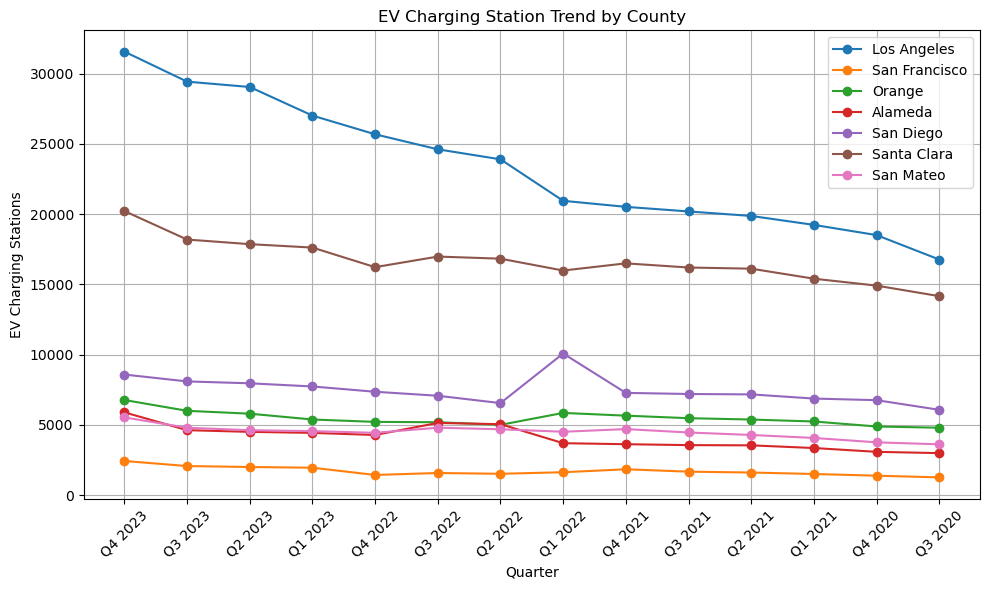

In [32]:
import matplotlib.pyplot as plt

# Selecting a subset of counties for demonstration
counties_to_plot = ['Los Angeles', 'San Francisco', 'Orange', 'Alameda', 'San Diego', 'Santa Clara', 'San Mateo']

plt.figure(figsize=(10, 6))

for county in counties_to_plot:
    county_data = df[df['County'] == county].iloc[:, 1:]  # Exclude 'County' column
    county_data = county_data.T.reset_index()
    county_data.columns = ['Quarter', 'EV Charging Stations']
    
    plt.plot(county_data['Quarter'], county_data['EV Charging Stations'], marker='o', label=county)

plt.xlabel('Quarter')
plt.ylabel('EV Charging Stations')
plt.title('EV Charging Station Trend by County')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Beginning of Mo (gas_price.ipynb)

In [33]:
import requests
import json


In [34]:
api_key = '4k9wboAV8W8ZdRVGqA9uIR:4LYhjC1Sx8VVuzdgg7P2uu'

In [35]:
from pprint import pprint

In [36]:
# url = "https://collectapi.com/api/gasPrice/gas-prices-api?tab=pricing"
url = "https://api.collectapi.com/gasPrice/stateUsaPrice?state="

In [37]:
headers = {
    'content-type': "application/json",
    'authorization': "apikey 3NHVADT5KuNLk3ZMn0THtC:2pmqCh12nXGVUWBbdn6wFy"
}

In [38]:
headers

{'content-type': 'application/json',
 'authorization': 'apikey 3NHVADT5KuNLk3ZMn0THtC:2pmqCh12nXGVUWBbdn6wFy'}

In [39]:
response = requests.get(url + "CA", headers=headers)

In [40]:
response.status_code

500

In [41]:
import http.client

conn = http.client.HTTPSConnection("api.collectapi.com")

headers = {
    'content-type': "application/json",
    'authorization': "apikey 3NHVADT5KuNLk3ZMn0THtC:2pmqCh12nXGVUWBbdn6wFy"
    }

conn.request("GET", "/gasPrice/stateUsaPrice?state=WA", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"success":false,"code":500,"message":"You do not have any subscription to this api."}


In [42]:
pprint(response.json())

{'code': 500,
 'message': 'You do not have any subscription to this api.',
 'success': False}


In [43]:
# api_key = "&apikey=" + api_key

In [44]:
import pandas as pd

In [45]:
data = response.json()

In [46]:
data = [{'currency': 'usd', 'gasoline': '4.834', 'midGrade': '5.059', 'premium': '5.246', 'diesel': '5.620', 'name': 'Bakersfield', 'lowerName': 'bakersfield'}, {'currency': 'usd', 'gasoline': '4.817', 'midGrade': '5.035', 'premium': '5.156', 'diesel': '5.130', 'name': 'Chico-Paradise', 'lowerName': 'chico-paradise'}, {'currency': 'usd', 'gasoline': '4.838', 'midGrade': '5.040', 'premium': '5.216', 'diesel': '5.393', 'name': 'Fresno', 'lowerName': 'fresno'}, {'currency': 'usd', 'gasoline': '4.975', 'midGrade': '5.187', 'premium': '5.330', 'diesel': '5.481', 'name': 'Los Angeles-Long Beach', 'lowerName': 'los angeles-long beach'}, {'currency': 'usd', 'gasoline': '4.894', 'midGrade': '5.099', 'premium': '5.279', 'diesel': '5.311', 'name': 'Merced', 'lowerName': 'merced'}, {'currency': 'usd', 'gasoline': '4.771', 'midGrade': '5.011', 'premium': '5.180', 'diesel': '5.300', 'name': 'Modesto', 'lowerName': 'modesto'}, {'currency': 'usd', 'gasoline': '4.993', 'midGrade': '5.206', 'premium': '5.387', 'diesel': '5.429', 'name': 'Oakland', 'lowerName': 'oakland'}, {'currency': 'usd', 'gasoline': '4.933', 'midGrade': '5.135', 'premium': '5.267', 'diesel': '5.278', 'name': 'Orange County', 'lowerName': 'orange county'}, {'currency': 'usd', 'gasoline': '4.765', 'midGrade': '4.918', 'premium': '5.064', 'diesel': '5.094', 'name': 'Redding', 'lowerName': 'redding'}, {'currency': 'usd', 'gasoline': '4.853', 'midGrade': '5.070', 'premium': '5.220', 'diesel': '5.282', 'name': 'Riverside', 'lowerName': 'riverside'}, {'currency': 'usd', 'gasoline': '4.940', 'midGrade': '5.141', 'premium': '5.324', 'diesel': '5.258', 'name': 'Sacramento', 'lowerName': 'sacramento'}, {'currency': 'usd', 'gasoline': '5.061', 'midGrade': '5.261', 'premium': '5.450', 'diesel': '5.621', 'name': 'Salinas', 'lowerName': 'salinas'}, {'currency': 'usd', 'gasoline': '4.972', 'midGrade': '5.180', 'premium': '5.335', 'diesel': '5.328', 'name': 'San Diego', 'lowerName': 'san diego'}, {'currency': 'usd', 'gasoline': '5.111', 'midGrade': '5.307', 'premium': '5.500', 'diesel': '5.529', 'name': 'San Francisco', 'lowerName': 'san francisco'}, {'currency': 'usd', 'gasoline': '4.952', 'midGrade': '5.154', 'premium': '5.327', 'diesel': '5.383', 'name': 'San Jose', 'lowerName': 'san jose'}, {'currency': 'usd', 'gasoline': '5.080', 'midGrade': '5.284', 'premium': '5.449', 'diesel': '5.808', 'name': 'San Luis Obispo-Atascadero-Paso Robles', 'lowerName': 'san luis obispo-atascadero-paso robles'}, {'currency': 'usd', 'gasoline': '4.971', 'midGrade': '5.162', 'premium': '5.304', 'diesel': '5.517', 'name': 'Santa Barbara-Santa Maria-Lompoc', 'lowerName': 'santa barbara-santa maria-lompoc'}, {'currency': 'usd', 'gasoline': '4.969', 'midGrade': '5.187', 'premium': '5.345', 'diesel': '5.556', 'name': 'Santa Cruz-Watsonville', 'lowerName': 'santa cruz-watsonville'}, {'currency': 'usd', 'gasoline': '5.098', 'midGrade': '5.301', 'premium': '5.472', 'diesel': '5.458', 'name': 'Santa Rosa', 'lowerName': 'santa rosa'}, {'currency': 'usd', 'gasoline': '4.828', 'midGrade': '5.046', 'premium': '5.226', 'diesel': '5.344', 'name': 'Stockton-Lodi', 'lowerName': 'stockton-lodi'}, {'currency': 'usd', 'gasoline': '4.907', 'midGrade': '5.112', 'premium': '5.280', 'diesel': '5.298', 'name': 'Vallejo-Fairfield', 'lowerName': 'vallejo-fairfield'}, {'currency': 'usd', 'gasoline': '5.015', 'midGrade': '5.218', 'premium': '5.362', 'diesel': '5.557', 'name': 'Ventura', 'lowerName': 'ventura'}, {'currency': 'usd', 'gasoline': '4.844', 'midGrade': '5.026', 'premium': '5.240', 'diesel': '5.458', 'name': 'Visalia-Tulare-Porterville', 'lowerName': 'visalia-tulare-porterville'}, {'currency': 'usd', 'gasoline': '4.900', 'midGrade': '5.132', 'premium': '5.343', 'diesel': '5.154', 'name': 'Yolo', 'lowerName': 'yolo'}, {'currency': 'usd', 'gasoline': '4.744', 'midGrade': '4.936', 'premium': '5.135', 'diesel': '5.158', 'name': 'Yuba City', 'lowerName': 'yuba city'}, {'currency': 'usd', 'gasoline': '4.772', 'midGrade': '4.962', 'premium': '5.187', 'diesel': '5.526', 'name': 'El Centro', 'lowerName': 'el centro'}, {'currency': 'usd', 'gasoline': '4.745', 'midGrade': '4.931', 'premium': '5.123', 'diesel': '5.316', 'name': 'Hanford-Corcoran', 'lowerName': 'hanford-corcoran'}, {'currency': 'usd', 'gasoline': '4.811', 'midGrade': '4.986', 'premium': '5.268', 'diesel': '5.532', 'name': 'Madera-Chowchilla', 'lowerName': 'madera-chowchilla'}, {'currency': 'usd', 'gasoline': '5.081', 'midGrade': '5.273', 'premium': '5.453', 'diesel': '5.391', 'name': 'Napa', 'lowerName': 'napa'}, {'currency': 'usd', 'gasoline': '4.891', 'midGrade': '5.078', 'premium': '5.243', 'diesel': '5.320', 'name': 'San Bernardino', 'lowerName': 'san bernardino'}, {'currency': 'usd', 'gasoline': '5.077', 'midGrade': '5.249', 'premium': '5.464', 'diesel': '5.460', 'name': 'San Rafael', 'lowerName': 'san rafael'}]


In [47]:
df = pd.DataFrame(data)

In [48]:
df.columns = ["currency", "gasoline", "midGrade", "premium", "diesel", "name", "lowerName"]

In [49]:
df.to_excel('gas_price_3.xlsx',index=False)

# Ending of Mo

# Beginning of Jim (presentation_1_jlh.ipynb)

# Presentation 1 Group 9 Analysis

- EV vehicles.
  

### Library Imports & Load of Files

In [50]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

# File to Load - 
census_df = Path('Resources/census_data.csv')  # UPDATE http://www.ecdms.energy.ca.gov/elecbyCounty.aspx
vehicle_type_by_zipcode_2020 = Path('Resources/vehicle_type_by_zipcode_2020.csv')
vehicle_type_by_zipcode_2021 = Path('Resources/vehicle_type_by_zipcode_2021.csv')
vehicle_type_by_zipcode_2022 = Path('Resources/vehicle_type_by_zipcode_2022.csv')
vehicle_type_by_zipcode_2022


census_df = pd.read_csv(census_df)
vehicle_type_by_zipcode_2020 = pd.read_csv(vehicle_type_by_zipcode_2020, low_memory=False)
vehicle_type_by_zipcode_2021 = pd.read_csv(vehicle_type_by_zipcode_2021, low_memory=False)
vehicle_type_by_zipcode_2022 = pd.read_csv(vehicle_type_by_zipcode_2022, low_memory=False)

#### DMV DATA 

In [51]:
# Perform initial review of DMV dataframe

vehicle_type_by_zipcode_2022

,Date,Zip Code,Model Year,Fuel,Make,Duty,Vehicles
0,1/1/2022,90000,2020,Gasoline,OTHER/UNK,Light,1
1,1/1/2022,90000,2022,Gasoline,OTHER/UNK,Light,1
2,1/1/2022,90000,<2008,Gasoline,OTHER/UNK,Heavy,22
3,1/1/2022,90000,<2008,Gasoline,OTHER/UNK,Light,20
4,1/1/2022,90000,<2008,Gasoline,OTHER/UNK,Unk,12
...,...,...,...,...,...,...,...
722460,1/1/2022,OOS,<2008,Flex-Fuel,CHRYSLER,Light,24
722461,1/1/2022,OOS,<2008,Flex-Fuel,CHRYSLER,Unk,26
722462,1/1/2022,OOS,<2008,Flex-Fuel,MAZDA,Light,14
722463,1/1/2022,OOS,<2008,Flex-Fuel,MERCURY,Light,20


In [52]:
# Generate DMV dataframe
# Determine the total number of vehicles with battery for years 2020
# Cleanes dataframe
# Match Census dataframe

battery_2020 = vehicle_type_by_zipcode_2020.loc[vehicle_type_by_zipcode_2020['Fuel'] == 'Battery Electric'] # locate battety vehicles
battery_2020 = battery_2020.drop(columns=['Model Year', 'Fuel', 'Make', 'Duty']) # drop unnecessary series
battery_2020 = battery_2020[battery_2020['Zip Code'] != 'OOS'] # cleanse by dropping "OOS" zip codes  
battery_2020 = battery_2020.replace('1/1/2020', 2020) # replacing Date to match DMV data
battery_2020 = battery_2020.sort_values('Zip Code') # sort on Zip Code
vehicle_count_2020 = battery_2020['Vehicles'].sum() # add all battery vechiles 2020
print('#############################')
print('EV count for 2020 is :', vehicle_count_2020)
print('#############################','\n\n')
battery_2020

#############################
EV count for 2020 is : 302841
############################# 




,Date,Zip Code,Vehicles
565720,2020,90000,4
442176,2020,90001,3
307116,2020,90001,1
483884,2020,90001,6
505993,2020,90001,2
...,...,...,...
399652,2020,98922,1
399653,2020,99205,1
399654,2020,99223,1
485315,2020,99502,1


In [53]:
# Generate battery vehcile DMV dataframe 
# Determine the total number of vehicles with battery for years 2020
# Cleanes dataframe
# Match Census dataframe

battery_2020 = vehicle_type_by_zipcode_2020.loc[vehicle_type_by_zipcode_2020['Fuel'] == 'Battery Electric'] # locate battety vehicles
battery_2020 = battery_2020.drop(columns=['Model Year', 'Fuel', 'Make', 'Duty']) # drop unnecessary series
battery_2020 = battery_2020[battery_2020['Zip Code'] != 'OOS'] # cleanse by dropping "OOS" zip codes  
battery_2020 = battery_2020.replace('1/1/2020', 2020) # replacing Date to match DMV data
battery_2020 = battery_2020.sort_values('Zip Code') # sort on Zip Code
vehicle_count_2020 = battery_2020['Vehicles'].sum() # add all battery vechiles 2020
print('#############################')
print('EV count for 2020 is :', vehicle_count_2020)
print('#############################','\n\n')
battery_2020

#############################
EV count for 2020 is : 302841
############################# 




,Date,Zip Code,Vehicles
565720,2020,90000,4
442176,2020,90001,3
307116,2020,90001,1
483884,2020,90001,6
505993,2020,90001,2
...,...,...,...
399652,2020,98922,1
399653,2020,99205,1
399654,2020,99223,1
485315,2020,99502,1


In [54]:
# Repeat preceding cell to determine the total number of vehicles with battery for years 2021

battery_2021 = vehicle_type_by_zipcode_2021.loc[vehicle_type_by_zipcode_2021['Fuel'] == 'Battery Electric']
battery_2021 = battery_2021.drop(columns=['Model Year', 'Fuel', 'Make', 'Duty'])
battery_2021 = battery_2021[battery_2021['Zip Code'] != 'OOS']
battery_2021 = battery_2021.replace('1/1/2021', 2021)
battery_2021 = battery_2021.sort_values('Zip Code')
vehicle_count_2021 = battery_2021['Vehicles'].sum()

print('#############################')
print('EV count for 2021 is :', vehicle_count_2021)
print('#############################','\n')
battery_2021

#############################
EV count for 2021 is : 371134
############################# 



,Date,Zip Code,Vehicles
248317,2021,90001,2
545279,2021,90001,13
156594,2021,90001,2
400089,2021,90001,3
348520,2021,90001,3
...,...,...,...
412381,2021,98922,1
412392,2021,99019,1
412394,2021,99021,1
462557,2021,99801,1


In [55]:
# Repeat preceding cells to determine the total number of vehicles with battery for years 2022
battery_2022 = vehicle_type_by_zipcode_2022.loc[vehicle_type_by_zipcode_2022['Fuel'] == 'Battery Electric']
battery_2022 = battery_2022.drop(columns=['Model Year', 'Fuel', 'Make', 'Duty'])
battery_2022 = battery_2022[battery_2022['Zip Code'] != 'OOS']
battery_2022 = battery_2022.replace('1/1/2022', 2022)
battery_2022 = battery_2022.sort_values('Zip Code')
vehicle_count_2022 = battery_2022['Vehicles'].sum()

print('#############################')
print('EV count for 2022 is :', vehicle_count_2022)
print('#############################','\n')
battery_2022

#############################
EV count for 2022 is : 520345
############################# 



,Date,Zip Code,Vehicles
141,2022,90001,1
488,2022,90001,1
474,2022,90001,16
473,2022,90001,2
441,2022,90001,1
...,...,...,...
719552,2022,98584,1
719786,2022,98663,1
720105,2022,98944,1
720203,2022,99033,1


#### CENSUS DATA 

In [56]:
# Generate Census dataframe
# Determine the total number of zip codes for neighborhoods for California
# Cleanes data
# Match DMV data

# Create dataframe for years 2020, 2021, and 2022
census_df_2020 = census_df.loc[(census_df['Year'] == 2020)]
census_df_2021 = census_df.loc[census_df['Year'] == 2021]
census_df_2022 = census_df.loc[census_df['Year'] == 2022]
census_df_2020_2022 = census_df.loc[(census_df['Year'] == 2020) | (census_df['Year'] == 2021) | (census_df['Year'] == 2022)]

# Change zip code to match DMV data for years 2020, 2021, and 2022
census_df_2020 = census_df_2020.rename(columns={'Zipcode': 'Zip Code'})
census_df_2021 = census_df_2021.rename(columns={'Zipcode': 'Zip Code'})
census_df_2022 = census_df_2022.rename(columns={'Zipcode': 'Zip Code'})
census_df_2020_2022 = census_df_2020_2022.rename(columns={'Zipcode': 'Zip Code'})

# Drop unnecessary series
census_df_2020 = census_df_2020.drop(columns=['Population', 'state_abbr', 'state_fips', 'state', 'city'])
census_df_2021 = census_df_2021.drop(columns=['Population', 'state_abbr', 'state_fips', 'state', 'city'])
census_df_2022 = census_df_2022.drop(columns=['Population', 'state_abbr', 'state_fips', 'state', 'city'])
census_df_2020_2022 = census_df_2020_2022.drop(columns=['Population', 'state_abbr', 'state_fips', 'state', 'city'])

# Match Zip Code of DMV data
census_df_2020 = census_df_2020.rename(columns={'Zipcode': 'Zip Code'})
census_df_2021 = census_df_2021.rename(columns={'Zipcode': 'Zip Code'})
census_df_2022 = census_df_2022.rename(columns={'Zipcode': 'Zip Code'})
census_df_2020_2022 = census_df_2020_2022.rename(columns={'Zipcode': 'Zip Code'})

# Match County of DMV data
census_df_2020 = census_df_2020.rename(columns={'county': 'County'})
census_df_2021 = census_df_2021.rename(columns={'county': 'County'})
census_df_2022 = census_df_2022.rename(columns={'county': 'County'})
census_df_2020_2022 = census_df_2020_2022.rename(columns={'county': 'County'})

# Concatenate the DataFrames to create census dataframe for merging with DMV dataframe
census_df_2020_2022 = pd.concat([census_df_2020, census_df_2021, census_df_2022], ignore_index=True)
census_df_2020_2022.reset_index(drop=True, inplace=True)
census_df_2020_2022

,Zip Code,Household Income,Year,County
0,90001,48011.0,2020,Los Angeles
1,90002,42245.0,2020,Los Angeles
2,90003,42220.0,2020,Los Angeles
3,90004,52775.0,2020,Los Angeles
4,90005,42398.0,2020,Los Angeles
...,...,...,...,...
4285,96145,120714.0,2022,Placer
4286,96146,112500.0,2022,Placer
4287,96148,96786.0,2022,Placer
4288,96150,76980.0,2022,El Dorado


In [57]:
# Determine boundaries for upper-, middle- and lower-income levels
# Define boundaries as 27% and 75% quartiles for 2020

mean_2020 = census_df_2020['Household Income'].mean()
quartile_25_2020 = census_df_2020['Household Income'].quantile([0.25])
quartile_75_2020 = census_df_2020['Household Income'].quantile([0.75])
print('####################################################################')
#print('mean', mean_2020)
print('The 25% quartile of Household Income for 2020 is: ', quartile_25_2020)
print('The 75% quartile of Household Income for 2020 is: ', quartile_75_2020)
print('####################################################################','\n')
print('####################################################################')

# Define boundaries as 27% and 75% quartiles for 2021
mean_2021 = census_df_2021['Household Income'].mean()
quartile_25_2021 = census_df_2021['Household Income'].quantile([0.25])
quartile_75_2021 = census_df_2021['Household Income'].quantile([0.75])
#print('mean', mean_2021)
print('The 25% quartile of Household Income for 2021 is: ', quartile_25_2021)
print('The 75% quartile of Household Income for 2021 is: ', quartile_75_2021)
print('####################################################################','\n')
print('####################################################################')

# Define boundaries as 27% and 75% quartiles for 2022
mean_2022 = census_df_2022['Household Income'].mean()
quartile_25_2022 = census_df_2022['Household Income'].quantile([0.25])
quartile_75_2022 = census_df_2022['Household Income'].quantile([0.75])
#print('mean', mean_2022)
print('The 25% quartile of Household Income for 2022 is: ',quartile_25_2022)
print('The 75% quartile of Household Income for 2022 is: ',quartile_75_2022)
print('####################################################################''\n')

####################################################################
The 25% quartile of Household Income for 2020 is:  0.25    53870.75
Name: Household Income, dtype: float64
The 75% quartile of Household Income for 2020 is:  0.75    96681.0
Name: Household Income, dtype: float64
#################################################################### 

####################################################################
The 25% quartile of Household Income for 2021 is:  0.25    58177.0
Name: Household Income, dtype: float64
The 75% quartile of Household Income for 2021 is:  0.75    104462.75
Name: Household Income, dtype: float64
#################################################################### 

####################################################################
The 25% quartile of Household Income for 2022 is:  0.25    63959.75
Name: Household Income, dtype: float64
The 75% quartile of Household Income for 2022 is:  0.75    112068.0
Name: Household Income, dtype: float64
##########

In [58]:
# Merge DMV and Census dataframes 
# Determine total number of EVs in California for 2022, 2021, and 2022 

# Change Zip Code data to strings
census_df_2020['Zip Code'] = census_df_2020['Zip Code'].apply(str) 
census_df_2021['Zip Code'] = census_df_2021['Zip Code'].apply(str)
census_df_2022['Zip Code'] = census_df_2022['Zip Code'].apply(str)

# Merge on Zip Code
merge_2020 = pd.merge(census_df_2020, battery_2020, how='left', on=['Zip Code'], sort=True)
merge_2021 = pd.merge(census_df_2021, battery_2021, how='left', on=['Zip Code'], sort=True)
merge_2022 = pd.merge(census_df_2022, battery_2022, how='left', on=['Zip Code'], sort=True)

# Drop NaN values arising from merge
merge_2020 = merge_2020.dropna(subset=['Date', 'Vehicles'])
merge_2021 = merge_2021.dropna(subset=['Date', 'Vehicles'])
merge_2022 = merge_2022.dropna(subset=['Date', 'Vehicles'])

# Merge on DMV and Census dataframes
merge_vehicle_count_2020 = merge_2020['Vehicles'].sum()
merge_vehicle_count_2021 = merge_2021['Vehicles'].sum()
merge_vehicle_count_2022 = merge_2022['Vehicles'].sum()

print('##########################################################')
print('The total vehicle count after merge for 2020 is ', merge_vehicle_count_2020)
print('The total vehicle count after merge for 2021 is ', merge_vehicle_count_2021)
print('The total vehicle count after merge for 2022 is ', merge_vehicle_count_2022)
print('##########################################################','\n')

##########################################################
The total vehicle count after merge for 2020 is  274385.0
The total vehicle count after merge for 2021 is  335157.0
The total vehicle count after merge for 2022 is  468753.0
########################################################## 



In [59]:
# Determine total vehicles counts per zip codes for years 2020, 2021, and 2022
# Use Zip Codes to define neighborhoods 

total_vehicle_count_by_zipcode_2020_df = merge_2020.groupby(['Zip Code', 'Household Income', 'County'], as_index=False, sort=True)['Vehicles'].sum()
total_vehicle_count_by_zipcode_2021_df = merge_2021.groupby(['Zip Code', 'Household Income', 'County'], as_index=False, sort=True)['Vehicles'].sum()
total_vehicle_count_by_zipcode_2022_df = merge_2022.groupby(['Zip Code', 'Household Income', 'County'], as_index=False, sort=True)['Vehicles'].sum()

In [60]:
# Determine total vehicles counts per 25% and 75% quartiles for years 2020, 2021, and 2022

total_vehicle_count_df_2020_75 = total_vehicle_count_by_zipcode_2020_df.loc[(total_vehicle_count_by_zipcode_2020_df['Household Income'] > int(quartile_75_2020))]
total_vehicle_count_df_2020_25 = total_vehicle_count_by_zipcode_2020_df.loc[(total_vehicle_count_by_zipcode_2020_df['Household Income'] < int(quartile_25_2020))]

total_vehicle_count_df_2021_75 = total_vehicle_count_by_zipcode_2021_df.loc[(total_vehicle_count_by_zipcode_2021_df['Household Income'] > int(quartile_75_2021))]
total_vehicle_count_df_2021_25 = total_vehicle_count_by_zipcode_2021_df.loc[(total_vehicle_count_by_zipcode_2021_df['Household Income'] < int(quartile_25_2021))]

total_vehicle_count_df_2022_75 = total_vehicle_count_by_zipcode_2022_df.loc[(total_vehicle_count_by_zipcode_2022_df['Household Income'] > int(quartile_75_2022))]
total_vehicle_count_df_2022_25 = total_vehicle_count_by_zipcode_2022_df.loc[(total_vehicle_count_by_zipcode_2022_df['Household Income'] < int(quartile_25_2022))]

total_vehicle_count_df_2020_75.reset_index(drop=True, inplace=True)
total_vehicle_count_df_2020_25.reset_index(drop=True, inplace=True)
total_vehicle_count_df_2021_75.reset_index(drop=True, inplace=True)
total_vehicle_count_df_2021_25.reset_index(drop=True, inplace=True)
total_vehicle_count_df_2022_75.reset_index(drop=True, inplace=True)
total_vehicle_count_df_2022_25.reset_index(drop=True, inplace=True)
total_vehicle_count_df_2022_25

C:\Users\jhaug\AppData\Local\Temp\ipykernel_10984\1860780555.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  total_vehicle_count_df_2020_75 = total_vehicle_count_by_zipcode_2020_df.loc[(total_vehicle_count_by_zipcode_2020_df['Household Income'] > int(quartile_75_2020))]
C:\Users\jhaug\AppData\Local\Temp\ipykernel_10984\1860780555.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  total_vehicle_count_df_2020_25 = total_vehicle_count_by_zipcode_2020_df.loc[(total_vehicle_count_by_zipcode_2020_df['Household Income'] < int(quartile_25_2020))]
C:\Users\jhaug\AppData\Local\Temp\ipykernel_10984\1860780555.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  total_vehicle_count_df_2021_75 = total_vehicle_count

,Zip Code,Household Income,County,Vehicles
0,90001,57698.0,Los Angeles,52.0
1,90002,54221.0,Los Angeles,60.0
2,90003,51275.0,Los Angeles,63.0
3,90004,58420.0,Los Angeles,643.0
4,90005,49226.0,Los Angeles,286.0
...,...,...,...,...
307,96107,43800.0,Mono,2.0
308,96122,53764.0,Plumas,9.0
309,96134,49327.0,Siskiyou,2.0
310,96137,59280.0,Lassen,7.0


In [61]:
# Determine vehicle count per quartile for each county

vehicle_count_by_county_df_2020_75 = total_vehicle_count_df_2020_75.groupby(['County'], as_index=False, sort=True)['Vehicles'].sum()
vehicle_count_by_county_df_2020_25 = total_vehicle_count_df_2020_25.groupby(['County'], as_index=False, sort=True)['Vehicles'].sum()
vehicle_count_by_county_df_2021_75 = total_vehicle_count_df_2021_75.groupby(['County'], as_index=False, sort=True)['Vehicles'].sum()
vehicle_count_by_county_df_2021_25 = total_vehicle_count_df_2021_25.groupby(['County'], as_index=False, sort=True)['Vehicles'].sum()
vehicle_count_by_county_df_2022_75 = total_vehicle_count_df_2022_75.groupby(['County'], as_index=False, sort=True)['Vehicles'].sum()
vehicle_count_by_county_df_2022_25 = total_vehicle_count_df_2022_25.groupby(['County'], as_index=False, sort=True)['Vehicles'].sum()
vehicle_count_by_county_df_2022_25

,County,Vehicles
0,Alameda,413.0
1,Amador,46.0
2,Butte,272.0
3,Calaveras,29.0
4,Colusa,12.0
5,Del Norte,44.0
6,Fresno,965.0
7,Glenn,6.0
8,Humboldt,312.0
9,Imperial,195.0


In [62]:
# Determine vehicle count per income levels in the state for years 2020, 2021, and 2022

vehicle_count_in_state_df_2020_75 = vehicle_count_by_county_df_2020_75['Vehicles'].sum()
vehicle_count_in_state_df_2020_25 = vehicle_count_by_county_df_2020_25['Vehicles'].sum()
vehicle_count_in_state_df_2021_75 = vehicle_count_by_county_df_2021_75['Vehicles'].sum()
vehicle_count_in_state_df_2021_25 = vehicle_count_by_county_df_2021_25['Vehicles'].sum()
vehicle_count_in_state_df_2022_75 = vehicle_count_by_county_df_2022_75['Vehicles'].sum()
vehicle_count_in_state_df_2022_25 = vehicle_count_by_county_df_2022_25['Vehicles'].sum()

total_vehicles_in_state_middle_income_2020 = merge_vehicle_count_2020 - vehicle_count_in_state_df_2020_75 - vehicle_count_in_state_df_2020_25
total_vehicles_in_state_middle_income_2021 = merge_vehicle_count_2021 - vehicle_count_in_state_df_2021_75 - vehicle_count_in_state_df_2021_25
total_vehicles_in_state_middle_income_2022 = merge_vehicle_count_2022 - vehicle_count_in_state_df_2022_75 - vehicle_count_in_state_df_2022_25

total_vehicles_in_state_middle_lower_income_2020 = total_vehicles_in_state_middle_income_2020 + vehicle_count_in_state_df_2020_25
total_vehicles_in_state_middle_lower_income_2021 = total_vehicles_in_state_middle_income_2021 + vehicle_count_in_state_df_2021_25
total_vehicles_in_state_middle_lower_income_2022 = total_vehicles_in_state_middle_income_2022 + vehicle_count_in_state_df_2022_25

year = ['2020','2021','2022']

state_income_level_counts_df = [['2020',  vehicle_count_in_state_df_2020_75, total_vehicles_in_state_middle_income_2020, vehicle_count_in_state_df_2020_25],
        ['2021', vehicle_count_in_state_df_2021_75, total_vehicles_in_state_middle_income_2021, vehicle_count_in_state_df_2021_25],
        ['2022', vehicle_count_in_state_df_2022_75, total_vehicles_in_state_middle_income_2022, vehicle_count_in_state_df_2022_25]]

state_income_level_counts_df = pd.DataFrame(state_income_level_counts_df, columns=['Year', 'Upper Income','Middle Income','Lower Income'])
state_income_level_counts_df.set_index('Year', inplace=True)
state_income_level_counts_df 

,Upper Income,Middle Income,Lower Income
Year,,,
2020,174336.0,90421.0,9628.0
2021,201606.0,120324.0,13227.0
2022,268235.0,180061.0,20457.0


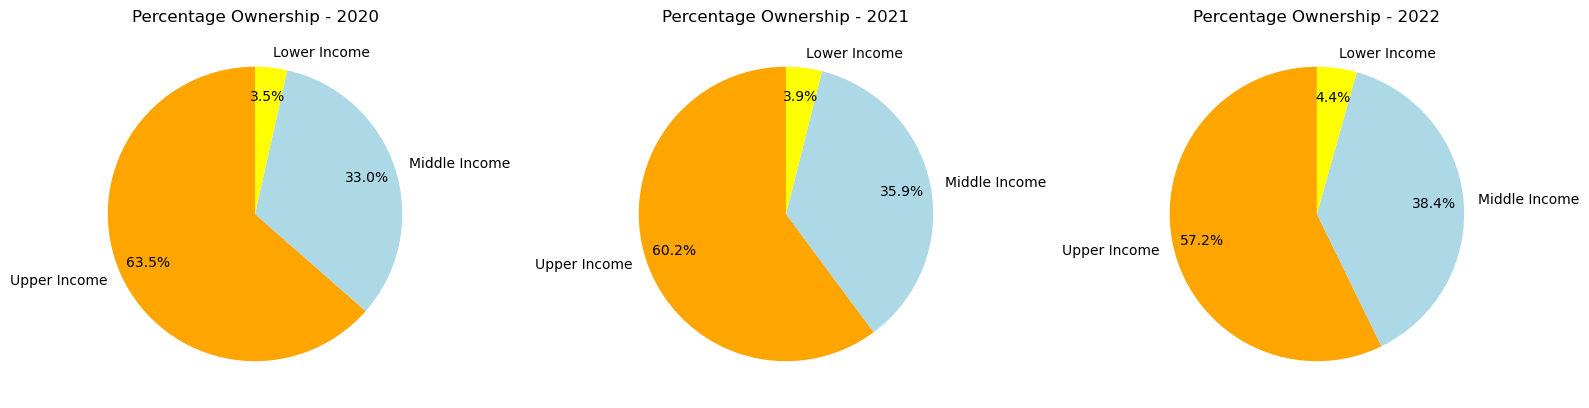

In [63]:
# Generate one pie chart for years 2020, 2021, and 2022 indicating percentage owning EVs per income level

income_level_labels = [
    'Upper Income', 'Middle Income', 'Lower Income'
]

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(16,16))

for i, year in enumerate(state_income_level_counts_df.index):
    state_income_level_counts_df.loc[year].plot.pie(ax=axes[i], 
                                                    colors=['orange', 'lightblue', 'yellow'], 
                                                    autopct='%.1f%%', 
                                                    pctdistance=.8, startangle=90)
    axes[i].set_title(f'Percentage Ownership - {year}')
    axes[i].set(ylabel="")

plt.tight_layout()  # Adjust spacing between subplots
plt.show() 

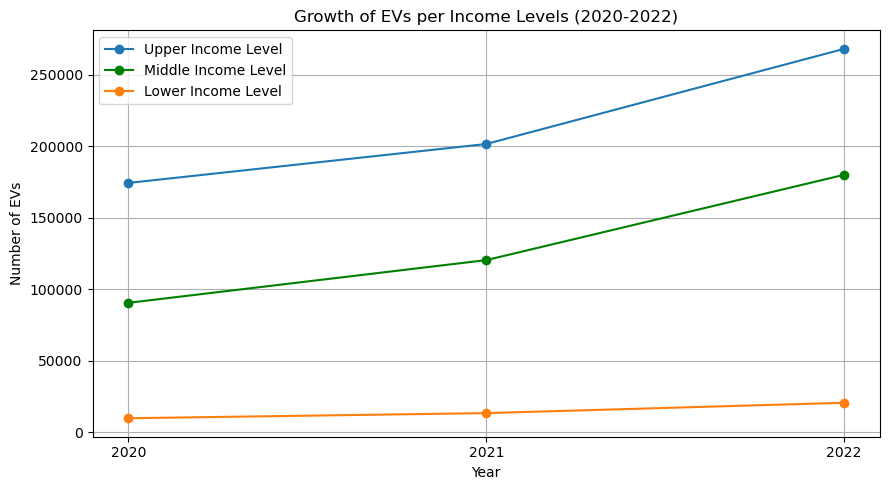

In [64]:
# Generate linear graph showing the trends of EV ownership per income level

Top = {
     'Upper 2020' : vehicle_count_in_state_df_2020_75,
     'Upper 2021' : vehicle_count_in_state_df_2021_75,   
     'Upper 2022' : vehicle_count_in_state_df_2022_75 
}

Middle = {
     'Middle 2020' : total_vehicles_in_state_middle_income_2020, 
     'Middle 2021' : total_vehicles_in_state_middle_income_2021,   
     'Middle 2022' : total_vehicles_in_state_middle_income_2022
 }

Lower = {
     'Lower 2020' : vehicle_count_in_state_df_2020_25,
     'Lower 2021' : vehicle_count_in_state_df_2021_25,   
     'Lower 2022' : vehicle_count_in_state_df_2022_25
 }
    
year = ['2020','2021','2022']
vehicles_2020 = list(Top.values())
vehicles_2021 = list(Middle.values())
vehicles_2022 = list(Lower.values())

# Plotting
plt.figure(figsize=(9, 5))
plt.plot(year, vehicles_2020, label='Upper Income Level', marker='o')
plt.plot(year, vehicles_2021, label='Middle Income Level', color='green', marker='o')
plt.plot(year, vehicles_2022, label='Lower Income Level', marker='o')

# Customizing the plot
plt.xlabel('Year')
plt.ylabel('Number of EVs')
plt.title('Growth of EVs per Income Levels (2020-2022)')
plt.legend()
plt.grid(True)

#Show plot
plt.tight_layout()
plt.show()